## Stock Portfolio allocation Testing Using Stable Basline 3
*   Using Yahoo Finance API to collect End-of-date data for Portfolio allocation
*   Testing applying the trained agents on another set of stocks.



In [ ]:
!apt-get update

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Ign:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [962 kB]
Get:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Hit:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Ge

# Install neccessary python packages.

In [1]:
!pip install stable-baselines3[extra]
!pip install gym
!pip install yfinance
!pip install pandas
!pip install numpy
!pip install pandas_ta

  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218908 sha256=8fbdbadf63949e5a2ddb531e6002518fe80170424fcc5e7c18cce3a76ba50f17
  Stored in directory: /root/.cache/pip/wheels/7f/33/8b/50b245c5c65433cd8f5cb24ac15d97e5a3db2d41a8b6ae957d
Successfully built pandas_ta


### Data Loading
Collecting data from Yahoo Finance.

In [2]:
import yfinance as yf
import pandas as pd

def get_data_from_yahoo(tic_list, start_date='2009-01-01', end_date='2024-01-01'):
    """
    Fetch OHLCV data from Yahoo Finance for a list of tickers and fill missing data.

    Args:
    - tic_list (list): List of stock tickers.
    - start_date (str): Start date for fetching data.
    - end_date (str): End date for fetching data.

    Returns:
    - pd.DataFrame: DataFrame containing OHLCV data for all tickers with missing data filled.
    """
    # Download historical data for all stocks
    all_df = pd.DataFrame()
    for tic in tic_list:
      df = yf.download(tic, start=start_date, end=end_date)
      df['tic'] = tic
      df = df.ffill()
      all_df = pd.concat([all_df, df])

    all_df = all_df.reset_index()
    all_df = all_df.set_index(['tic'])
    all_df = all_df.sort_index()  # Sort by date and ticker

    return all_df


### Add Technical Indicators and Covariance Matrix

In [3]:
import pandas_ta  as ta # Technical Analysis library
import numpy as np

def add_technical_indicators(df):
    """
    Add common technical indicators and calculate the covariance matrix for each stock pair.

    Args:
    - df (pd.DataFrame): DataFrame with OHLCV data.

    Returns:
    - pd.DataFrame: DataFrame with technical indicators and covariance matrix added.
    """
    # Sort by 'tic' and 'date' just to ensure proper ordering
    df = df.sort_values(by=['tic', 'Date'])

    # Add technical indicators
    df['SMA_10'] = df.groupby('tic')['Close'].transform(lambda x: ta.sma(x, length=10))
    df['SMA_50'] = df.groupby('tic')['Close'].transform(lambda x: ta.sma(x, length=50))
    df['SMA_200'] = df.groupby('tic')['Close'].transform(lambda x: ta.sma(x, length=200))
    df['EMA_10'] = df.groupby('tic')['Close'].transform(lambda x: ta.ema(x, length=10))
    df['RSI_14'] = df.groupby('tic')['Close'].transform(lambda x: ta.rsi(x, length=14))
    df['MACD'], df['MACD_signal'], df['MACD_hist'] = df.groupby('tic')['Close'].apply(lambda x: ta.macd(x, fast=12, slow=26, signal=9)).values.T.tolist()
    bbands = df.groupby('tic')['Close'].apply(lambda x: ta.bbands(x, length=20, std=2))
    df['BBL'], df['BBM'], df['BBU'] = bbands[['BBL_20_2.0', 'BBM_20_2.0', 'BBU_20_2.0']].values.T
    df['ATR_14'] = df.groupby('tic').apply(lambda x: ta.atr(x['High'], x['Low'], x['Close'], length=14)).reset_index(level=0, drop=True)
    df['Stochastic_K'], df['Stochastic_D'] = df.groupby('tic').apply(lambda x: ta.stoch(x['High'], x['Low'], x['Close'], fast_k=14, slow_d=3)).values.T
    df['CCI_14'] = df.groupby('tic').apply(lambda x: ta.cci(x['High'], x['Low'], x['Close'], length=14)).reset_index(level=0, drop=True).tolist()
    df['ADX_14'] = df.groupby('tic').apply(lambda x: ta.adx(x['High'], x['Low'], x['Close'], length=14)).reset_index(level=0, drop=True)[['ADX_14']]
    df['OBV'] = df.groupby('tic').apply(lambda x: ta.obv(x['Close'], x['Volume'])).reset_index(level=0, drop=True).tolist()
    df['WILLR_14'] = df.groupby('tic').apply(lambda x: ta.willr(x['High'], x['Low'], x['Close'], length=14)).reset_index(level=0, drop=True)
    df['ROC_10'] = df.groupby('tic')['Close'].transform(lambda x: ta.roc(x, length=10))
    df['Vortex_Pos'], df['Vortex_Neg'] = df.groupby('tic').apply(lambda x: ta.vortex(x['High'], x['Low'], x['Close'], length=14)).values.T
    df['ATR_14'] = df.groupby('tic').apply(lambda x: ta.atr(x['High'], x['Low'], x['Close'], length=14)).reset_index(level=0, drop=True)

    return df




In [4]:
def add_covariance_matrix(df, tic_list, window=252):
    """
    Calculate the covariance matrix for each stock pair in the given time window.

    Args:
    - df (pd.DataFrame): DataFrame with OHLCV data.
    - tic_list (list): List of stock tickers.
    - window (int): Time window for calculating covariance matrix. default is 252 trading days in a year

    Returns:
    - pd.DataFrame: DataFrame with covariances are added per stock per date
    """

    # Calculate the covariance matrix for the past year for each stock pair
    # We'll use a rolling window of 252 trading days (1 year)
    # window = 252  # 252 trading days in a year
    cov_df = pd.DataFrame()

    # Pivot the data to create a wide-format DataFramce for calculating covariance
    df = df.reset_index()
    Close_prices = df.pivot(index='Date',columns='tic', values='Close')

    for i in range(window, len(Close_prices)):
      cov_matrix = Close_prices.iloc[i-window:i].pct_change().dropna()
      cov_matrix = cov_matrix.cov()
      cov_matrix['Date'] = Close_prices.index[i]
      cov_df = pd.concat([cov_df, cov_matrix])

    cov_df = cov_df.reset_index()
    cov_df = cov_df.set_index(['Date', 'tic'])
    df = df.set_index(['Date', 'tic'])
    # Add the covariance matrix to the DataFrame
    df = pd.concat([df, cov_df], axis=1)

    # Fill any remaining NaNs after adding indicators
    df = df.fillna(0)

    return df


Testing

In [5]:
tic_list = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'BRK-B', 'JNJ', 'V',
            'WMT', 'JPM', 'PG', 'UNH', 'DIS', 'HD', 'MA', 'BAC', 'VZ', 'KO',
            'ADBE', 'NFLX', 'PFE', 'INTC', 'CSCO', 'PEP', 'MRK', 'ABT', 'T', 'XOM']


In [6]:
df = get_data_from_yahoo(tic_list)
df.info()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

<class 'pandas.core.frame.DataFrame'>
Index: 105672 entries, AAPL to XOM
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Date       105672 non-null  datetime64[ns]
 1   Open       105672 non-null  float64       
 2   High       105672 non-null  float64       
 3   Low        105672 non-null  float64       
 4   Close      105672 non-null  float64       
 5   Adj Close  105672 non-null  float64       
 6   Volume     105672 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 6.4+ MB


In [7]:
df = add_technical_indicators(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 105672 entries, AAPL to XOM
Data columns (total 28 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Date          105672 non-null  datetime64[ns]
 1   Open          105672 non-null  float64       
 2   High          105672 non-null  float64       
 3   Low           105672 non-null  float64       
 4   Close         105672 non-null  float64       
 5   Adj Close     105672 non-null  float64       
 6   Volume        105672 non-null  int64         
 7   SMA_10        105420 non-null  float64       
 8   SMA_50        104300 non-null  float64       
 9   SMA_200       100100 non-null  float64       
 10  EMA_10        105420 non-null  float64       
 11  RSI_14        105280 non-null  float64       
 12  MACD          104972 non-null  float64       
 13  MACD_signal   104972 non-null  float64       
 14  MACD_hist     104972 non-null  float64       
 15  BBL           105140 n

In [8]:
df = add_covariance_matrix(df, tic_list)
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 105672 entries, (Timestamp('2009-01-02 00:00:00'), 'AAPL') to (Timestamp('2023-12-29 00:00:00'), 'XOM')
Data columns (total 55 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Open          105672 non-null  float64
 1   High          105672 non-null  float64
 2   Low           105672 non-null  float64
 3   Close         105672 non-null  float64
 4   Adj Close     105672 non-null  float64
 5   Volume        105672 non-null  int64  
 6   SMA_10        105672 non-null  float64
 7   SMA_50        105672 non-null  float64
 8   SMA_200       105672 non-null  float64
 9   EMA_10        105672 non-null  float64
 10  RSI_14        105672 non-null  float64
 11  MACD          105672 non-null  float64
 12  MACD_signal   105672 non-null  float64
 13  MACD_hist     105672 non-null  float64
 14  BBL           105672 non-null  float64
 15  BBM           105672 non-null  float64
 16  BBU           10

In [9]:
df.head()

,,Open,High,Low,Close,Adj Close,Volume,SMA_10,SMA_50,SMA_200,EMA_10,...,NVDA,PEP,PFE,PG,T,UNH,V,VZ,WMT,XOM
Date,tic,,,,,,,,,,,,,,,,,,,,,
2009-01-02,AAPL,3.067143,3.251429,3.041429,3.241071,2.737004,746015200,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-01-05,AAPL,3.327500,3.435000,3.311071,3.377857,2.852517,1181608400,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-01-06,AAPL,3.426786,3.470357,3.299643,3.322143,2.805468,1289310400,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-01-07,AAPL,3.278929,3.303571,3.223571,3.250357,2.744846,753048800,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-01-08,AAPL,3.229643,3.326786,3.215714,3.310714,2.795816,673500800,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Define the GYM env for stock portfolio allocation.


In [10]:
from os import truncate
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd

class PortfolioAllocationEnv(gym.Env):
    """
    Custom Environment that follows gym interface.
    This is a stock portfolio allocation environment.
    """
    def __init__(self, df, initial_balance=10000, tic_list=None, transaction_fee_rate=0.001, logfile=None):
      """
      Initializes the environment.
      df = the stock trading information and features for training the agents.
      initial_balance = the starting balance for creating the portfolio.
      tic_list = the list of stocks to be included in the portfolio.
      """
      super(PortfolioAllocationEnv, self).__init__()

      # Stock Data
      self.df = df
      self.tic_list = tic_list
      self.n_stocks = len(self.tic_list)

      #Initial Setup
      self.initial_balance = initial_balance
      self.balance = initial_balance
      self.current_step = 0
      self.done = False
      self.episode = 0

      # Porfolio Weights (initially all cash)
      self.portfolio_weights = np.array([1] + [0] * self.n_stocks, dtype=float)
      self.holdings = np.zeros(self.n_stocks, dtype=float)
      # current_date = self.df.index.get_level_values(0).unique()[self.current_step]
      # current_data = self.df.loc[current_date]
      # self.prices = current_data['Close'].values
      self.portfolio_value = self.balance
      self.trading_dates = self.df.index.get_level_values(0).unique()

      # Transaction fee rate
      self.transaction_fee_rate = transaction_fee_rate

      # Action Space
      self.action_space = spaces.Box(low=0, high=1, shape=(self.n_stocks + 1,), dtype=np.float64)


      # Observation Space
      # All stocks' technical indicators and covariance matrix are embeded in df.
      # Therefore, the features for a trading day is n_stock * len(df.columns).
      # Amount Cash balance is also included.
      # Portfolio weight is also included, n_stocks + 1, where 1 is the case balance.
      self.observation_space = spaces.Box(
        low=-np.inf,
        high=np.inf,
        shape=(self.n_stocks * len(df.columns) + 1 + self.n_stocks + 1,),
        dtype=np.float64
      )

      # Memory for traking
      self._action_memory = []
      self._portfolio_value_memory = [self.balance]
      self._reward_memory = []
      self._final_weights_memory = [self.portfolio_weights]
      self._transaction_fees = []
      self.logfile = logfile

    def reset(self, seed=None, options=None):
      """
      Resets the environment to the initial state.
      """
      # Seed the environment (ensure reproducibility)
      if seed is not None:
        np.random.seed(seed)

      if ((self.episode % 5) == 0) and (self.episode > 0):
        performance_metric = self._calculate_portfolio_metrics()
        print(performance_metric)
        logdata = self.log_episode()
        log_df = pd.DataFrame(logdata)
        log_df.set_index('Dates', inplace=True)
        print((log_df.head()))


      # reset environment state
      self.balance = self.initial_balance
      self.current_step = 0
      self.done = False
      self.portfolio_weights = np.array([1] + [0] * self.n_stocks, dtype=float)
      self.holdings = np.zeros(self.n_stocks, dtype=float)
      self.portfolio_value = self.balance
      self._action_memory = []
      self._portfolio_value_memory = [self.balance]
      self._reward_memory = []
      self._final_weights_memory = [self.portfolio_weights]
      self._transaction_fees = []
      self.episode += 1

      # Return the initial observation
      return self._get_observation(), {}

    def step(self, action):
      """
      Execute one time step within the environment.

      Args:
      - action: The portfolio weights (cash + stocks) provided by the agent.

      Returns:
      - observation: The new state after the action.
      - reward: The reward for the current step.
      - done: Whether the episode is over.
      - info: Additional information (empty in this case).
      """
      # Execute the action (rebalance the portfolio)
      current_prices = self._get_close_prices(self.current_step)
      self._take_action(action, current_prices)

      # Advance to the next step
      self.current_step += 1

      # Update the portfolio value and weights after the action
      next_prices = self._get_close_prices(self.current_step)
      self._update_portfolio_value(next_prices)

      # Calculate reward based on the change in portfolio value
      reward = self._calculate_reward()

      # Store the action in memory
      self._action_memory.append(action)
      self._reward_memory.append(reward)  # Store the reward in memory

      # Store the updated portfolio value in memory
      self._portfolio_value_memory.append(self.portfolio_value)

      # Store the updated portfolio weights in memory
      self._final_weights_memory.append(self.portfolio_weights.copy())

      # Check if we're
      terminated = self.current_step >= len(self.trading_dates) - 1
      truncated = False  # This could be set to True if truncate the episode would be used

      # Get the new observation
      observation = self._get_observation()

      return observation, reward, terminated, truncated, {}

    def _normalize_action(self, action):
      """
      Normalize the action (weights) to ensure they sum to 1.
      The action represents the target portfolio weights for cash and stocks.

      Args:
      - action: A raw action array of shape (n_stocks + 1,), where the first element
                is the cash allocation and the remaining elements are for the stocks.

      Returns:
      - A normalized action (portfolio weights) that sum to 1.
      """
      # Clip the action to ensure no negative weights
      action = np.clip(action, 1e-8, None)

      # Ensure sufficient cash balance at step 0 to pay the transaction fee when initial
      # position setup.
      if (self.current_step == 0):
        if ((action[0] / np.sum(action)) < 0.01): # less than 1% cash
          # print(f"Too little cash allocated: {action[0]} / {np.sum(action)}.")
          action[0] = np.sum(action[1:]) / 99 # make cash to be 1%
          
      # Normalize the action so that the sum of the weights equals 1
      # Using softmax function that ensures all action elements are > 0 and the sum equals 1
      exp_action = np.exp(action - np.max(action))  # Subtract max to avoid overflow
      return exp_action / np.sum(exp_action)


    def _get_close_prices(self, step):
      """
      Get the 'Close' prices of all tickers at the specified step (date).
      """
      # Get the current date corresponding to the step
      current_date = self.df.index.get_level_values(0).unique()[step]

      # Filter the DataFrame for this date (all tickers)
      current_data = self.df.loc[current_date]

      # Extract the 'Close' prices for all tickers on the current date
      close_prices = current_data['Close']

      return close_prices

    def _take_action(self, action, current_prices):
      """
      Execute the action (rebalancing), update the number of shares (self.holdings),
      and adjust the cash balance (self.balance), considering transaction fees.

      Args:
      - action: The target portfolio weights provided by the agent.
      - current_prices: The current close prices of the stocks.
      """
      # Normalize the action
      action = self._normalize_action(action)

      # Target cash allocation and stock allocations (dollar amounts)
      target_stock_allocations = action[1:] * self.portfolio_value

      # Current stock allocations (dollar amounts)
      current_stock_allocations = self.holdings * current_prices

      # Deltas represent changes in stock allocations (buy/sell)
      deltas = target_stock_allocations - current_stock_allocations

      # Calculate transaction fees
      transaction_fees = np.abs(deltas) * self.transaction_fee_rate
      self._transaction_fees.append(np.sum(transaction_fees))
      

      # Calculate net cash flow from trades
      net_cash_flow = np.sum(deltas) # Positive: cash needed, Negative: cash generated from selling

      # Total cost includes transaction fees and cash required for buys
      total_transaction_cost = np.sum(transaction_fees) + net_cash_flow

      if total_transaction_cost > self.balance:
          # If there's insufficient cash, reject the action
          # print(f"Insufficient funds. Transaction cost: {total_transaction_cost}, Available cash: {self.balance}")
          return

      # Update holdings (new number of shares for each stock)
      self.holdings = target_stock_allocations / current_prices

      # Update cash balance (account for transaction fees and cash spent/received)
      self.balance -= total_transaction_cost

      # Debug information (optional)
      # print(f"Action taken: {action}")
      # print(f"Target stock allocations: {target_stock_allocations}")
      # print(f"Delta in stock allocations: {deltas}")
      # print(f"Transaction fees: {transaction_fees}")
      # print(f"New cash balance: {self.balance}")
      # print(f"New cash balance: {self.holdings}")
      # print(f"New portfolio weights: {self.portfolio_weights}")

    def _update_portfolio_value(self, current_prices):
      """
      Update the portfolio value based on current stock prices and holdings, and update portfolio weights.

      Args:
      - current_prices: The current close prices of the stocks.
      """
      # Step 1: Calculate the value of stock holdings (number of shares * current prices)
      stock_values = np.sum(self.holdings * current_prices)

      # Step 2: Update the total portfolio value (stock values + cash balance)
      self.portfolio_value = self.balance + stock_values

      # Step 3: Update the portfolio weights based on the new portfolio value
      #         All weights sum up to 1
      self.portfolio_weights[1:] = (self.holdings * current_prices) / self.portfolio_value  # Stock weights
      self.portfolio_weights[0] = self.balance / self.portfolio_value  # Cash weight


    def _calculate_reward(self):
      """
      Calculate the reward based on the change in portfolio value.
      """
      #reward = self.portfolio_value / self.initial_balance -1
      reward = self.portfolio_value

      return reward


    def _get_observation(self):
      """
      Returns the observation, which includes:
      - Market data: OHLCV, technical indicators, and covariances for all stocks.
      - Portfolio weights and cash balance.
      """
      # Get the current date's data (OHLCV, technical indicators, covariances) for all tickers
      current_date = self.df.index.get_level_values(0).unique()[self.current_step]
      current_data = self.df.loc[current_date]

      # Combine OHLCV, technical indicators, and covariances
      market_data = current_data.values.flatten()
      obs = np.concatenate([
          market_data,
          self.portfolio_weights,
          [self.balance]
      ])

      return obs

    def render(self, mode='human'):
      """
      Render the environment.
      Output useful information like portfolio value, holdings, stock prices, etc.
      """
      if self.current_step >= len(self.df.index.get_level_values(0).unique()) - 1:
        # Calculate and print the portfolio metrics
        metrics = self._calculate_portfolio_metrics()

        print(f"End of Episode Metrics:")
        print(f"Cumulative Return: {metrics['Cumulative Return']:.2f}")
        print(f"Sharpe Ratio: {metrics['Sharpe Ratio']:.2f}")
        print(f"Max Drawdown: {metrics['Max Drawdown']:.2f}")
        print(f"Volatility: {metrics['Volatility']:.2f}")
        print("="*50)

      # Get the current date corresponding to the current step
      current_date = self.df.index.get_level_values(0).unique()[self.current_step]

      # Get the close prices for the current step
      current_prices = self._get_close_prices(self.current_step)

      # Display key information
      print(f"Step: {self.current_step}")
      print(f"Date: {current_date}")
      print(f"Portfolio Value: {self.portfolio_value:.2f}")
      print(f"Cash Balance: {self.balance:.2f}")
      print(f"Stock Prices: {current_prices}")
      print(f"Portfolio Weights: {self.portfolio_weights}")
      print("="*50)

    def _calculate_portfolio_metrics(self):
      """
      Calculate portfolio performance metrics like Sharpe Ratio, Max Drawdown, and Volatility.
      - Cumulative return is based on the final value of the portfolio.
      - Daily returns are calculated from the change in portfolio value between steps.

      Returns:
      - Dictionary with portfolio performance metrics.
      """
      # Convert cumulative rewards to portfolio values
      portfolio_values = np.array(self._portfolio_value_memory)

      # 1. Cumulative Return: Final portfolio value vs. initial balance
      cumulative_return = portfolio_values[-1] / portfolio_values[0] - 1

      # 2. Daily Returns: Compute daily returns from portfolio values
      daily_returns = np.diff(portfolio_values) / portfolio_values[:-1]

      # 3. Sharpe Ratio: Mean return divided by the standard deviation of returns
      mean_return = np.mean(daily_returns)
      std_return = np.std(daily_returns)
      sharpe_ratio = mean_return / (std_return + 1e-6)  # Avoid division by zero

      # 4. Max Drawdown: The maximum drop from peak portfolio value to trough
      peak_value = np.maximum.accumulate(portfolio_values)
      drawdown = (peak_value - portfolio_values) / peak_value
      max_drawdown = np.max(drawdown)

      # 5. Volatility: Standard deviation of daily returns
      volatility = std_return

      return {
          'Cumulative Return': cumulative_return,
          'Sharpe Ratio': sharpe_ratio,
          'Max Drawdown': max_drawdown,
          'Volatility': volatility
      }
    
    def log_episode(self):
      """
      Save the details of the episode, including actions, portfolio values, and other metrics.
      """

      steps = range((len(self._action_memory)))
      dates = self.trading_dates[steps]

      episode_log = {
          'Episode': [self.episode] * len(self._action_memory),
          'Dates': dates,
          'Actions': self._action_memory,
          'Portfolio Values': self._portfolio_value_memory[1:],
          'Transaction Costs': self._transaction_fees,
          'Weights': self._final_weights_memory[1:],
      }

      # Convert to DataFrame
      log_df = pd.DataFrame(episode_log)

      if self.logfile:
          # Append the log to CSV (use mode='a' to append, header=False if the file already exists)
          log_df.to_csv(self.logfile, mode='a', header=not pd.io.common.file_exists(self.logfile), index=False)

      return episode_log


### Split the Data from 2010-2019 for training and using 2020-2022 for validation.

In [11]:
# Split the dataset based on the 'Date' or first level of the multi-index
train_df = df.loc[(df.index.get_level_values(0) >= '2010-01-01') & (df.index.get_level_values(0) <= '2019-12-31')]
validation_df = df.loc[(df.index.get_level_values(0) >= '2020-01-01') & (df.index.get_level_values(0) <= '2021-12-31')]
trade_df = df.loc[(df.index.get_level_values(0) >= '2022-01-01') & (df.index.get_level_values(0) <= '2023-12-31')]


### Creating the Environment

### Training the RL Agents
Train multiple RL models such as DQN, PPO, and A2C using the train_env.

*   Here, 'MlpPolicy' is a neural network policy that processes observations (e.g., prices, portfolio weights, etc.) and outputs the actions.
*  total_timesteps=100000 specifies the number of time steps you want to train the models for. You can adjust this depending on the complexity of your environment and desired training length.





In [12]:
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.005,
    "learning_rate": 0.0001,
    "batch_size": 128,
}

A2C_PARAMS = {
    "n_steps": 5, 
    "ent_coef": 0.005, 
    "learning_rate": 0.0002
}

DDPG_PARAMS = {
    "batch_size": 128, 
    "buffer_size": 50000, 
    "learning_rate": 0.001
}

In [13]:
from stable_baselines3 import PPO, A2C, DDPG

# Create environment
env = PortfolioAllocationEnv(df=train_df, initial_balance=100000, tic_list=tic_list, transaction_fee_rate=0.001)

# Train PPO
ppo_model = PPO("MlpPolicy", env, verbose=1, **PPO_PARAMS)
ppo_model.learn(total_timesteps=100000)


2024-09-19 11:34:35.024633: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-19 11:34:35.073781: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-19 11:34:35.087360: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-19 11:34:35.167312: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 231  |
|    iterations      | 1    |
|    time_elapsed    | 8    |
|    total_timesteps | 2048 |
-----------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 2.52e+03      |
|    ep_rew_mean          | 2.72e+08      |
| time/                   |               |
|    fps                  | 224           |
|    iterations           | 2             |
|    time_elapsed         | 18            |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 2.4097972e-08 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -41.1         |
|    explained_variance   | -1.31e-06     |
|    learning_rate        | 0.0001 

In [14]:

# Train A2C
a2c_model = A2C("MlpPolicy", env, verbose=1, **A2C_PARAMS)
a2c_model.learn(total_timesteps=100000)


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
{'Cumulative Return': 0.2663772098883608, 'Sharpe Ratio': 0.016099799049835776, 'Max Drawdown': 0.20414676242695123, 'Volatility': 0.008979717251305482}
            Episode                                            Actions  \
Dates                                                                    
2010-01-04       40  [0.0, 0.0, 0.9722187519073486, 0.9891601204872...   
2010-01-05       40  [0.14010891318321228, 0.0, 0.0, 0.519849359989...   
2010-01-06       40  [0.0, 0.0, 0.0, 0.0, 0.5458788275718689, 0.067...   
2010-01-07       40  [0.0, 0.0, 0.0, 0.1049659252166748, 0.26519668...   
2010-01-08       40  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5380302071571...   

            Portfolio Values  Transaction Costs  \
Dates                                             
2010-01-04      99841.288719          97.543503   
2010-01-05      99463.700010          34.051373   
2010-01-06      99150.018383 

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.52e+03 |
|    ep_rew_mean        | 2.98e+08 |
| time/                 |          |
|    fps                | 210      |
|    iterations         | 1500     |
|    time_elapsed       | 35       |
|    total_timesteps    | 7500     |
| train/                |          |
|    entropy_loss       | -40.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 1499     |
|    policy_loss        | 1.72e+07 |
|    std                | 0.993    |
|    value_loss         | 2.32e+11 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.52e+03 |
|    ep_rew_mean        | 2.99e+08 |
| time/                 |          |
|    fps                | 210      |
|    iterations         | 1600     |
|    time_elapsed       | 38       |
|    total_timesteps    | 8000     |
|

In [15]:

# Train DDPG
ddpg_model = DDPG("MlpPolicy", env, verbose=1, **DDPG_PARAMS)
ddpg_model.learn(total_timesteps=100000)


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
{'Cumulative Return': 0.4651222704652158, 'Sharpe Ratio': 0.027302410520542837, 'Max Drawdown': 0.17937388441245525, 'Volatility': 0.008689871325207543}
            Episode                                            Actions  \
Dates                                                                    
2010-01-04       80  [0.4959580898284912, 0.0, 0.640777587890625, 0...   
2010-01-05       80  [0.0, 0.777306854724884, 0.0, 0.0, 0.0, 0.0, 1...   
2010-01-06       80  [0.3412645757198334, 0.0, 1.0, 0.0, 0.0, 0.0, ...   
2010-01-07       80  [0.0, 0.0, 1.0, 0.6500519514083862, 0.0, 0.0, ...   
2010-01-08       80  [1.0, 0.0, 0.5894854664802551, 0.1340211033821...   

            Portfolio Values  Transaction Costs  \
Dates                                             
2010-01-04     100037.535168          96.220027   
2010-01-05      99601.960748          31.174951   
2010-01-06      99366.882293 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.52e+03 |
|    ep_rew_mean     | 5.87e+08 |
| time/              |          |
|    episodes        | 4        |
|    fps             | 124      |
|    time_elapsed    | 80       |
|    total_timesteps | 10060    |
| train/             |          |
|    actor_loss      | 5.88e+07 |
|    critic_loss     | 9.08e+11 |
|    learning_rate   | 0.001    |
|    n_updates       | 9959     |
---------------------------------
{'Cumulative Return': 4.050413571041639, 'Sharpe Ratio': 0.07630517564264028, 'Max Drawdown': 0.17550002601269615, 'Volatility': 0.00896845792958339}
            Episode                                            Actions  \
Dates                                                                    
2010-01-04       85  [0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...   
2010-01-05       85  [0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...   
2010-01-06       85  [0.0, 1.0, 0.0, 1.0, 0.

In [16]:
import os

# Create the directory if it doesn't exist
model_dir = "./IRP/models"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)


In [17]:
# Save PPO model to the "./models" directory
ppo_model.save(os.path.join(model_dir, "ppo_portfolio_model"))

# Save other models similarly
a2c_model.save(os.path.join(model_dir, "a2c_portfolio_model"))
ddpg_model.save(os.path.join(model_dir, "ddpg_portfolio_model"))


In [18]:
!ls -l ./IRP/models/

total 737052
-rw-r--r-- 1 root root   1773493 Sep 19 12:03 a2c_portfolio_model.zip
-rw-r--r-- 1 root root  10137563 Sep 19 00:12 a2c_portfolio_model_ewc.zip
-rw-r--r-- 1 root root    740242 Sep 18 23:49 a2c_portfolio_model_group1_v1.zip
-rw-r--r-- 1 root root    740370 Sep 18 23:57 a2c_portfolio_model_navie.zip
-rw-r--r-- 1 root root    743018 Sep 19 01:48 a2c_portfolio_model_replay.zip
-rw-r--r-- 1 root root  24393578 Sep 19 12:03 ddpg_portfolio_model.zip
-rw-r--r-- 1 root root 665193317 Sep 19 00:19 ddpg_portfolio_model_ewc.zip
-rw-r--r-- 1 root root  11659395 Sep 18 23:49 ddpg_portfolio_model_group1_v1.zip
-rw-r--r-- 1 root root  11659523 Sep 19 00:02 ddpg_portfolio_model_navie.zip
-rw-r--r-- 1 root root  11661010 Sep 19 01:34 ddpg_portfolio_model_replay.zip
-rw-r--r-- 1 root root   2623433 Sep 19 12:03 ppo_portfolio_model.zip
-rw-r--r-- 1 root root  10137534 Sep 19 00:06 ppo_portfolio_model_ewc.zip
-rw-r--r-- 1 root root   1084252 Sep 18 23:49 ppo_portfolio_model_group1_v1.zip
-rw-

In [19]:
# Download historical data for DJI (^DJI) from yfinance
dji_train_data = yf.download('^DJI', start='2010-01-01', end='2019-12-31')
dji_data = yf.download('^DJI', start='2022-01-01', end='2023-12-31')


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [20]:
def test_agent_performance(agent, env):
    """
    Test the agent on the test dataset and track portfolio values indexed by date.
    """
    obs, _ = env.reset()
    done = False

    # Initialize a dictionary to store portfolio values indexed by date
    portfolio_values = {}
    
    # Get the list of dates from the test environment's dataframe (index level 0)
    dates = env.df.index.get_level_values(0).unique()

    # Add the initial portfolio value with the first date
    portfolio_values[dates[0]] = env.initial_balance

    step = 0
    while not done:
        action, _ = agent.predict(obs)
        obs, reward, done, truncated, _ = env.step(action)
        step += 1

        # Record the portfolio value for the current date
        portfolio_values[dates[step]] = env.portfolio_value

    # Convert the dictionary to a Pandas Series for easy plotting and comparison
    portfolio_values_series = pd.Series(portfolio_values)

    # Calculate cumulative return
    cumulative_return = (portfolio_values_series.iloc[-1] / portfolio_values_series.iloc[0]) - 1

    return portfolio_values_series, cumulative_return


In [21]:
def plot_agent_performance_multiple_envs(model_files, envs, benchmarks, title):
    """
    General function to plot cumulative returns for multiple agents over multiple environments,
    handling MultiIndex DataFrames with 'date' in the index, and displaying dates on the x-axis.
    
    Parameters:
    - model_files: dict, {name: (model_class, filename)}, where name is a string identifier for the agent,
      model_class is the class (e.g., PPO, A2C, DDPG), and filename is the path to the saved model.
    - envs: dict, {env_name: environment}, where env_name is a string identifier for the environment.
    - benchmarks: dict, {env_name: (benchmark_name, benchmark_prices)}, where benchmark_name is the benchmark name,
      benchmark_prices is a pandas Series with datetime index of benchmark prices.
    - title: string, the title of the plot.
    """
    import matplotlib.pyplot as plt
    import pandas as pd
    import matplotlib.dates as mdates

    num_envs = len(envs)
    fig, axes = plt.subplots(1, num_envs, figsize=(12 * num_envs, 10), sharex=False)
    if num_envs == 1:
        axes = [axes]

    for idx, (env_name, env) in enumerate(envs.items()):
        agent_cumulative_returns = {}
        for name, (model_class, filename) in model_files.items():
            # Load the model
            model = model_class.load(filename, env=env)

            # Test the agent performance
            portfolio_values, _ = test_agent_performance(model, env)

            # Calculate cumulative returns over time
            cumulative_returns = (portfolio_values / portfolio_values.iloc[0]) - 1

            # Since cumulative_returns is already indexed by dates, we can use it directly
            agent_cumulative_returns[name] = cumulative_returns

        # Get benchmark for this environment
        benchmark_name, benchmark_prices = benchmarks[env_name]

        # Align benchmark cumulative returns with the test period
        env_dates = agent_cumulative_returns[next(iter(agent_cumulative_returns))].index
        benchmark_period = benchmark_prices.loc[benchmark_prices.index.isin(env_dates)]

        # Handle potential missing dates by reindexing
        benchmark_period = benchmark_period.reindex(env_dates, method='ffill')

        # Calculate cumulative returns
        benchmark_cumulative_returns = (benchmark_period / benchmark_period.iloc[0]) - 1

        # Plot cumulative returns
        ax = axes[idx]
        for name, cumulative_returns in agent_cumulative_returns.items():
            ax.plot(cumulative_returns.index, cumulative_returns.values, label=name)

        # Add benchmark cumulative returns
        ax.plot(benchmark_cumulative_returns.index, benchmark_cumulative_returns.values,
                label=benchmark_name, linestyle="--")

        ax.set_title(f"{title} - {env_name}")
        ax.set_xlabel("Date")
        ax.set_ylabel("Cumulative Return")
        ax.legend()
        ax.grid(True)

        # Format x-axis dates
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    plt.tight_layout()
    plt.show()


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


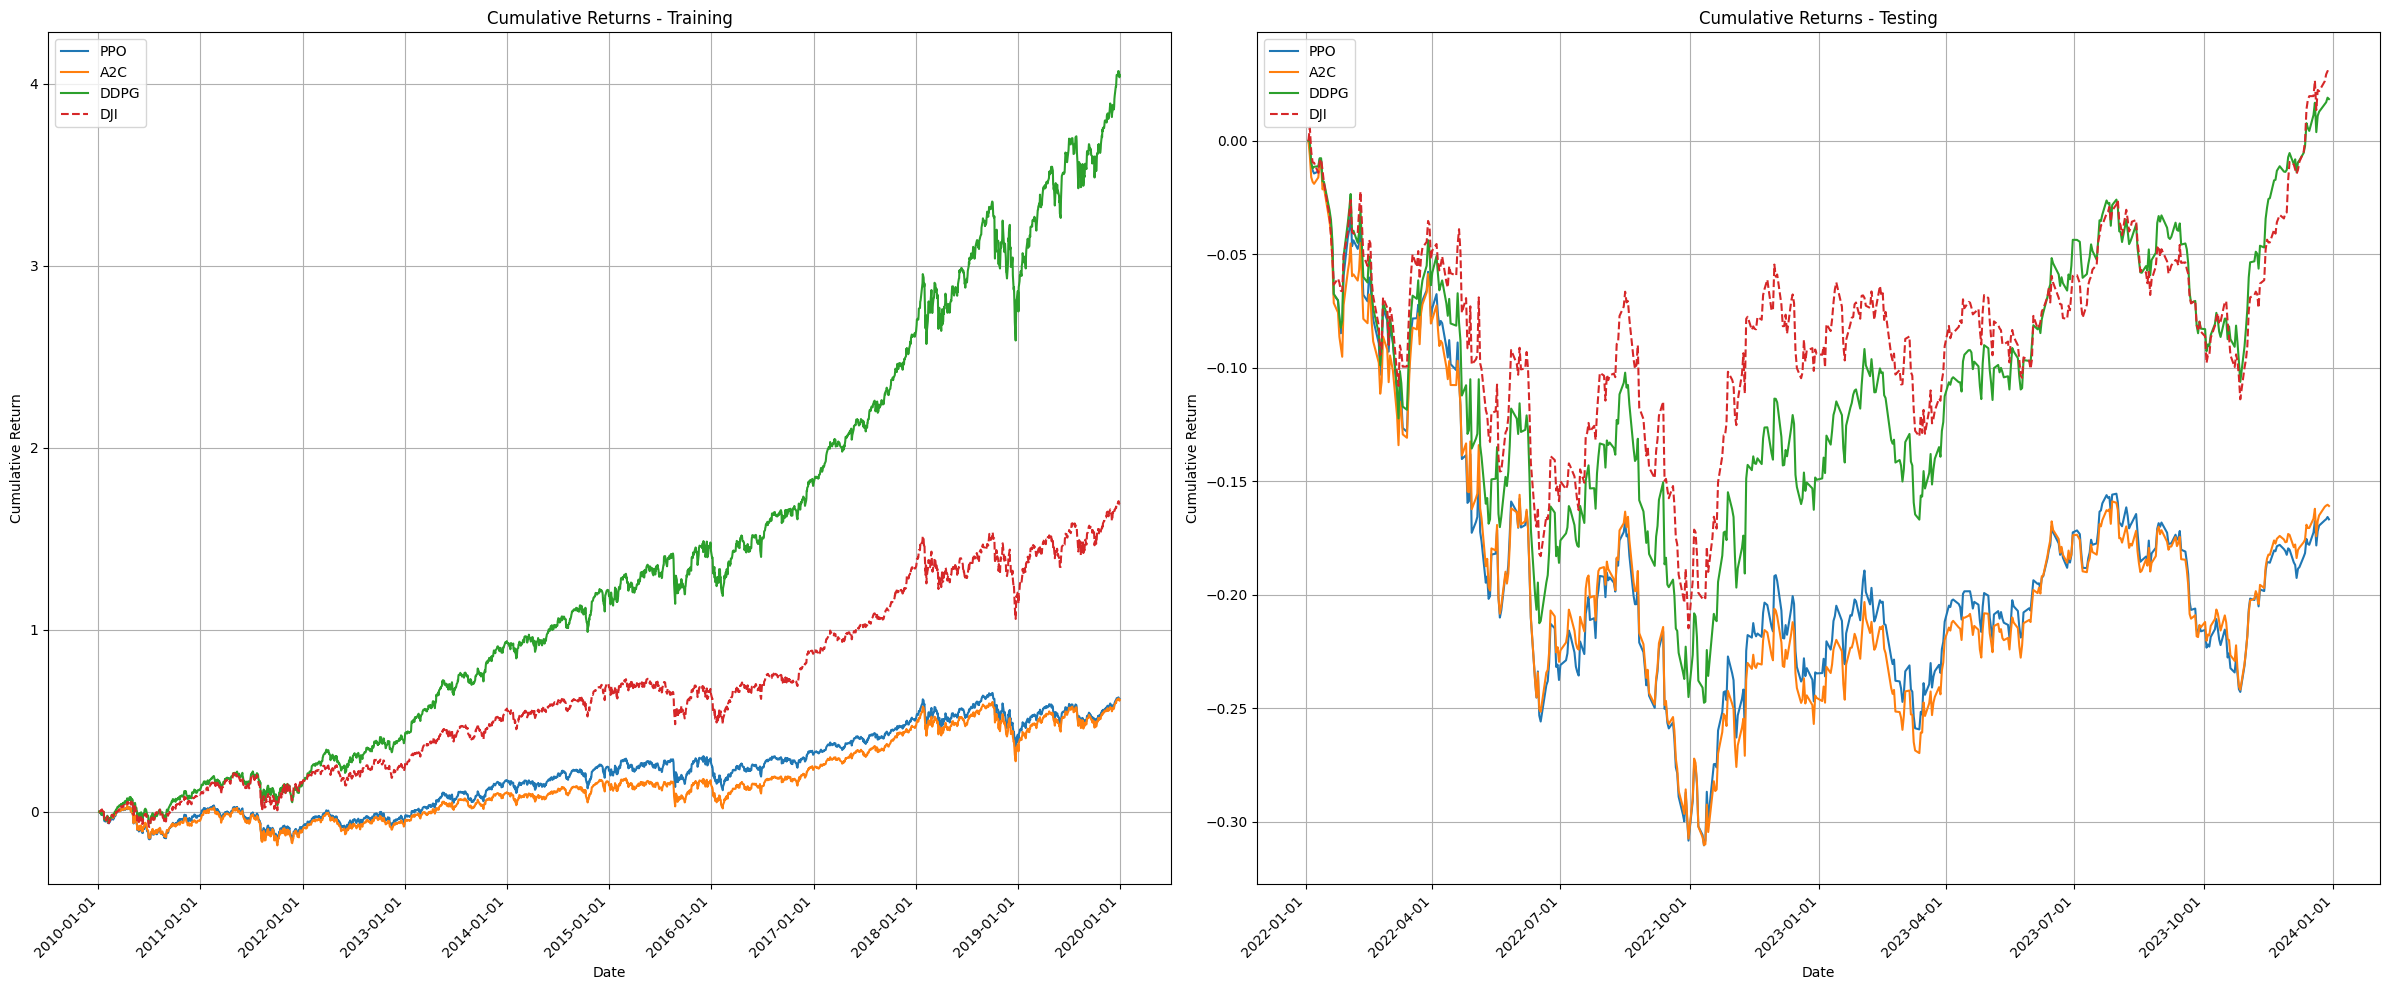

In [22]:
from stable_baselines3 import PPO, A2C, DDPG

# Define the models with their respective classes and filenames
model_files = {
    'PPO': (PPO, os.path.join(model_dir, "ppo_portfolio_model")),
    'A2C': (A2C, os.path.join(model_dir, "a2c_portfolio_model")),
    'DDPG': (DDPG, os.path.join(model_dir, "ddpg_portfolio_model"))
}

# Create the test environment
train_env = PortfolioAllocationEnv(df=train_df, initial_balance=100000, tic_list=tic_list, transaction_fee_rate=0.001)
test_env = PortfolioAllocationEnv(df=trade_df, initial_balance=100000, tic_list=tic_list, transaction_fee_rate=0.001)
envs = {
    'Training': train_env,
    'Testing': test_env
}

# Define the benchmark
benchmarks = {
    'Training':('DJI', dji_train_data['Close']),
    'Testing':('DJI', dji_data['Close'])
}

# Call the function
plot_agent_performance_multiple_envs(model_files, envs, benchmarks, "Cumulative Returns")


## Split the data set into 2 for testing Continual Learning techniques

### Splitting Data Set
The original data set will be split into 2.  Each contains the trading data of 14 stocks, which are selected randomly for each run.  The another 14 stocks' data will be used to test the performance after applying Continual Learning techniques.

### Continual Learning Techniques
1. Naive -  Just training the agents with additional data of the second half of the data.
2. Regulationization - Which apply controls how the update apply during learning of new data.
3. Experience Replay - Part of the original set of data will be replayed during the training using the new data.

In [23]:
import random

def split_collect_stock_data(tic_list, start_date='2009-01-01', end_date='2024-01-01'):
    """
    The function is to randomly generate 2 sets of stock trading data.
    
    Parameters:
    tic_list : A list of all stocks for collecting trading data
    start_date : The start date of the trading data
    end_date: The end date of the trading data

    Returns:
    group1, group2: the tickers list of the 2 data sets.
    df1, df2: 2 dataframes contain the trading data, technical indicators, and covariance.
    """

    tic_list_copy = tic_list.copy()
    random.shuffle(tic_list_copy)
    index = int(len(tic_list_copy)/2)
    group1 = tic_list_copy[:index]
    group2 = tic_list_copy[index:2*index]

    df1 = get_data_from_yahoo(group1, start_date, end_date)
    df1 = add_technical_indicators(df1)
    df1 = add_covariance_matrix(df1, group1)

    df2 = get_data_from_yahoo(group2, start_date, end_date)
    df2 = add_technical_indicators(df2)
    df2 = add_covariance_matrix(df2, group2)

    return group1, group2, df1, df2



In [24]:
group1,group2, df1, df2 = split_collect_stock_data(tic_list)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

### Split 2 sets of data into train, validation, and trade data sets

In [25]:
# Split the dataset based on the 'Date' or first level of the multi-index
train_df1 = df1.loc[(df1.index.get_level_values(0) >= '2010-01-01') & (df1.index.get_level_values(0) <= '2019-12-31')]
validation_df1 = df1.loc[(df1.index.get_level_values(0) >= '2020-01-01') & (df1.index.get_level_values(0) <= '2021-12-31')]
trade_df1 = df1.loc[(df1.index.get_level_values(0) >= '2022-01-01') & (df1.index.get_level_values(0) <= '2023-12-31')]

train_df2 = df2.loc[(df2.index.get_level_values(0) >= '2010-01-01') & (df2.index.get_level_values(0) <= '2019-12-31')]
validation_df2 = df2.loc[(df2.index.get_level_values(0) >= '2020-01-01') & (df2.index.get_level_values(0) <= '2021-12-31')]
trade_df2 = df2.loc[(df2.index.get_level_values(0) >= '2022-01-01') & (df2.index.get_level_values(0) <= '2023-12-31')]

In [26]:
from stable_baselines3 import PPO, A2C, DDPG

# Create environment
env = PortfolioAllocationEnv(df=train_df1, initial_balance=100000, tic_list=group1, transaction_fee_rate=0.001)

# Train PPO
ppo_model = PPO("MlpPolicy", env, verbose=1, **PPO_PARAMS)
ppo_model.learn(total_timesteps=50000)


# Train A2C
a2c_model = A2C("MlpPolicy", env, verbose=1, **A2C_PARAMS)
a2c_model.learn(total_timesteps=80000)

# Train DDPG
ddpg_model = DDPG("MlpPolicy", env, verbose=1, **DDPG_PARAMS)
ddpg_model.learn(total_timesteps=50000)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 305  |
|    iterations      | 1    |
|    time_elapsed    | 6    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.52e+03    |
|    ep_rew_mean          | 2.68e+08    |
| time/                   |             |
|    fps                  | 293         |
|    iterations           | 2           |
|    time_elapsed         | 13          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 1.44355e-08 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -21.3       |
|    explained_variance   | -2.03e-06   |
|    learning_rate        | 0.0001      |
|    loss              

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 2.52e+03      |
|    ep_rew_mean          | 2.81e+08      |
| time/                   |               |
|    fps                  | 292           |
|    iterations           | 4             |
|    time_elapsed         | 28            |
|    total_timesteps      | 8192          |
| train/                  |               |
|    approx_kl            | 1.3504177e-08 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -21.3         |
|    explained_variance   | 3.64e-06      |
|    learning_rate        | 0.0001        |
|    loss                 | 1.74e+12      |
|    n_updates            | 30            |
|    policy_gradient_loss | -8.54e-06     |
|    std                  | 1             |
|    value_loss           | 3.49e+12      |
-------------------------------------------
--------------------------------

In [27]:
# Save PPO model to the "./models" directory
ppo_model.save(os.path.join(model_dir, "ppo_portfolio_model_group1_v1"))

# Save other models similarly
a2c_model.save(os.path.join(model_dir, "a2c_portfolio_model_group1_v1"))
ddpg_model.save(os.path.join(model_dir, "ddpg_portfolio_model_group1_v1"))

In [28]:
!ls -l ./IRP/models/

total 737052
-rw-r--r-- 1 root root   1773493 Sep 19 12:03 a2c_portfolio_model.zip
-rw-r--r-- 1 root root  10137563 Sep 19 00:12 a2c_portfolio_model_ewc.zip
-rw-r--r-- 1 root root    740242 Sep 19 12:17 a2c_portfolio_model_group1_v1.zip
-rw-r--r-- 1 root root    740370 Sep 18 23:57 a2c_portfolio_model_navie.zip
-rw-r--r-- 1 root root    743018 Sep 19 01:48 a2c_portfolio_model_replay.zip
-rw-r--r-- 1 root root  24393578 Sep 19 12:03 ddpg_portfolio_model.zip
-rw-r--r-- 1 root root 665193317 Sep 19 00:19 ddpg_portfolio_model_ewc.zip
-rw-r--r-- 1 root root  11659395 Sep 19 12:17 ddpg_portfolio_model_group1_v1.zip
-rw-r--r-- 1 root root  11659523 Sep 19 00:02 ddpg_portfolio_model_navie.zip
-rw-r--r-- 1 root root  11661010 Sep 19 01:34 ddpg_portfolio_model_replay.zip
-rw-r--r-- 1 root root   2623433 Sep 19 12:03 ppo_portfolio_model.zip
-rw-r--r-- 1 root root  10137534 Sep 19 00:06 ppo_portfolio_model_ewc.zip
-rw-r--r-- 1 root root   1084252 Sep 19 12:17 ppo_portfolio_model_group1_v1.zip
-rw-

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


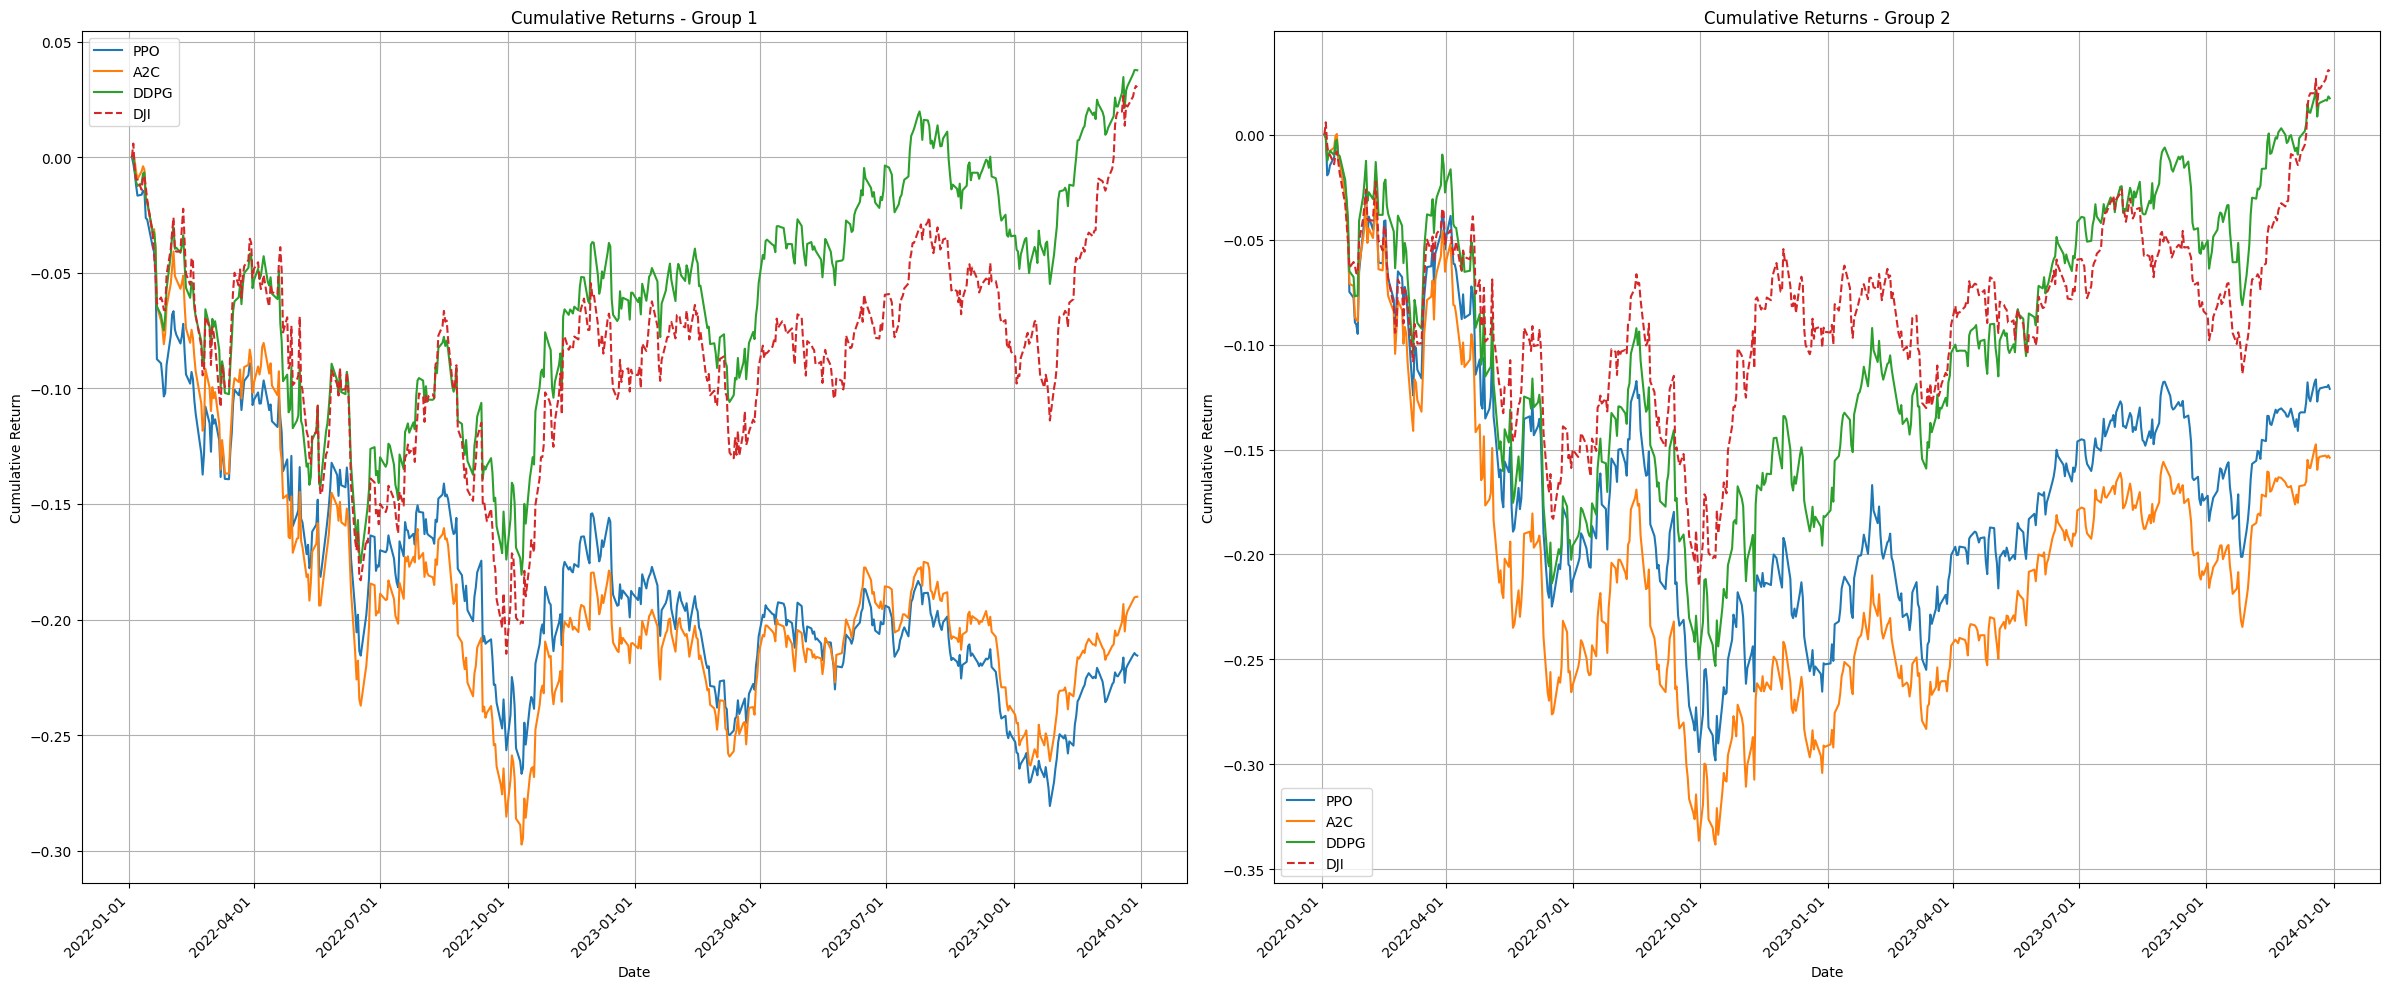

In [29]:
from stable_baselines3 import PPO, A2C, DDPG

# Define the models with their respective classes and filenames
model_files = {
    'PPO': (PPO, os.path.join(model_dir, "ppo_portfolio_model_group1_v1")),
    'A2C': (A2C, os.path.join(model_dir, "a2c_portfolio_model_group1_v1")),
    'DDPG': (DDPG, os.path.join(model_dir, "ddpg_portfolio_model_group1_v1"))
}

# Create the test environment
group1_env = PortfolioAllocationEnv(df=trade_df1, initial_balance=100000, tic_list=group1, transaction_fee_rate=0.001)
group2_env = PortfolioAllocationEnv(df=trade_df2, initial_balance=100000, tic_list=group2, transaction_fee_rate=0.001)
envs = {
    'Group 1': group1_env,
    'Group 2': group2_env
}

# Define the benchmark
benchmarks = {
    'Group 1':('DJI', dji_data['Close']),
    'Group 2':('DJI', dji_data['Close'])
}

# Call the function
plot_agent_performance_multiple_envs(model_files, envs, benchmarks, "Cumulative Returns")

In [30]:

def calculate_performance_metrics(portfolio_values, benchmark_values=None, risk_free_rate=0.0):
    """
    Calculate portfolio performance metrics based on time series of portfolio values.
    
    Parameters:
    - portfolio_values: pandas Series of portfolio values over time.
    - benchmark_values: (optional) pandas Series of benchmark values (e.g., index like DJI) over time.
    - risk_free_rate: (optional) Risk-free rate (annualized). Default is 0.0.
    
    Returns:
    - metrics: A dictionary containing performance metrics.
    """
    # Ensure portfolio values are a pandas Series
    portfolio_values = pd.Series(portfolio_values)
    
    # Calculate daily returns
    portfolio_returns = portfolio_values.pct_change().dropna()
    
    # Cumulative return
    cumulative_return = (portfolio_values.iloc[-1] - portfolio_values.iloc[0]) / portfolio_values.iloc[0]

    # Average daily return
    avg_daily_return = portfolio_returns.mean()
    
    # Annualized return
    annualized_return = (1 + avg_daily_return) ** 252 - 1
    
    # Volatility (annualized standard deviation of daily returns)
    volatility = portfolio_returns.std() * np.sqrt(252)
    
    # Sharpe Ratio
    sharpe_ratio = (annualized_return - risk_free_rate) / volatility if volatility != 0 else np.nan
    
    # Sortino Ratio (using downside risk)
    downside_returns = portfolio_returns[portfolio_returns < 0]
    downside_deviation = np.std(downside_returns) * np.sqrt(252)
    sortino_ratio = (annualized_return - risk_free_rate) / downside_deviation if downside_deviation != 0 else np.nan
    
    # Maximum Drawdown
    rolling_max = portfolio_values.cummax()
    drawdown = (portfolio_values - rolling_max) / rolling_max
    max_drawdown = drawdown.min()
    
    # Calmar Ratio
    calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown != 0 else np.nan
    
    # Alpha and Beta (if benchmark is provided)
    alpha, beta, treynor_ratio = np.nan, np.nan, np.nan
    if benchmark_values is not None:
        benchmark_returns = pd.Series(benchmark_values).pct_change().dropna()
        cov_matrix = np.cov(portfolio_returns, benchmark_returns)
        beta = cov_matrix[0, 1] / np.var(benchmark_returns)
        alpha = (annualized_return - risk_free_rate) - (beta * (np.mean(benchmark_returns) * 252 - risk_free_rate))
        treynor_ratio = (annualized_return - risk_free_rate) / beta if beta != 0 else np.nan

    # Value at Risk (VaR) at 95% confidence level using historical method
    var_95 = np.percentile(portfolio_returns, 5)
    
    # Compile metrics into a dictionary
    metrics = {
        'Cumulative Return': cumulative_return,
        'Volatility (Standard Deviation of Returns)': volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino_ratio,
        'Maximum Drawdown': max_drawdown,
        'Calmar Ratio': calmar_ratio,
        'Alpha': alpha,
        'Beta': beta,
        'VaR (95%)': var_95
    }
    
    return metrics


## Continual Learning Strategy:  Navie

The simplest strategy, also known as fine-tuning.  Based on the trained RL agents and continue training using additional data.  But it may prone to catrophic forgetting.

In [31]:
from stable_baselines3 import PPO, A2C, DDPG

# Creating Group 2 Training Environment
group2_env = PortfolioAllocationEnv(df=train_df2, initial_balance=100000, tic_list=group2, transaction_fee_rate=0.001)
navie_ppo_agent = PPO.load(os.path.join(model_dir, "ppo_portfolio_model_group1_v1"), env=group2_env)
navie_ppo_agent.learn(total_timesteps=50000)
navie_ppo_agent.save(os.path.join(model_dir, "ppo_portfolio_model_navie"))

group2_env = PortfolioAllocationEnv(df=train_df2, initial_balance=100000, tic_list=group2, transaction_fee_rate=0.001)
navie_a2c_agent = A2C.load(os.path.join(model_dir, "a2c_portfolio_model_group1_v1"), env=group2_env)
navie_a2c_agent.learn(total_timesteps=80000)
navie_a2c_agent.save(os.path.join(model_dir, "a2c_portfolio_model_navie"))

group2_env = PortfolioAllocationEnv(df=train_df2, initial_balance=100000, tic_list=group2, transaction_fee_rate=0.001)
navie_ddpg_agent = DDPG.load(os.path.join(model_dir, "ddpg_portfolio_model_group1_v1"), env=group2_env)
navie_ddpg_agent.learn(total_timesteps=50000)
navie_ddpg_agent.save(os.path.join(model_dir, "ddpg_portfolio_model_navie"))


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 306  |
|    iterations      | 1    |
|    time_elapsed    | 6    |
|    total_timesteps | 2048 |
-----------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 2.52e+03      |
|    ep_rew_mean          | 3.16e+08      |
| time/                   |               |
|    fps                  | 297           |
|    iterations           | 2             |
|    time_elapsed         | 13            |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 1.2340024e-08 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -21.3         |
|    explained_variance   | 6.5e-06       |
|    learning_rate        | 0.0001        |
|    loss

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


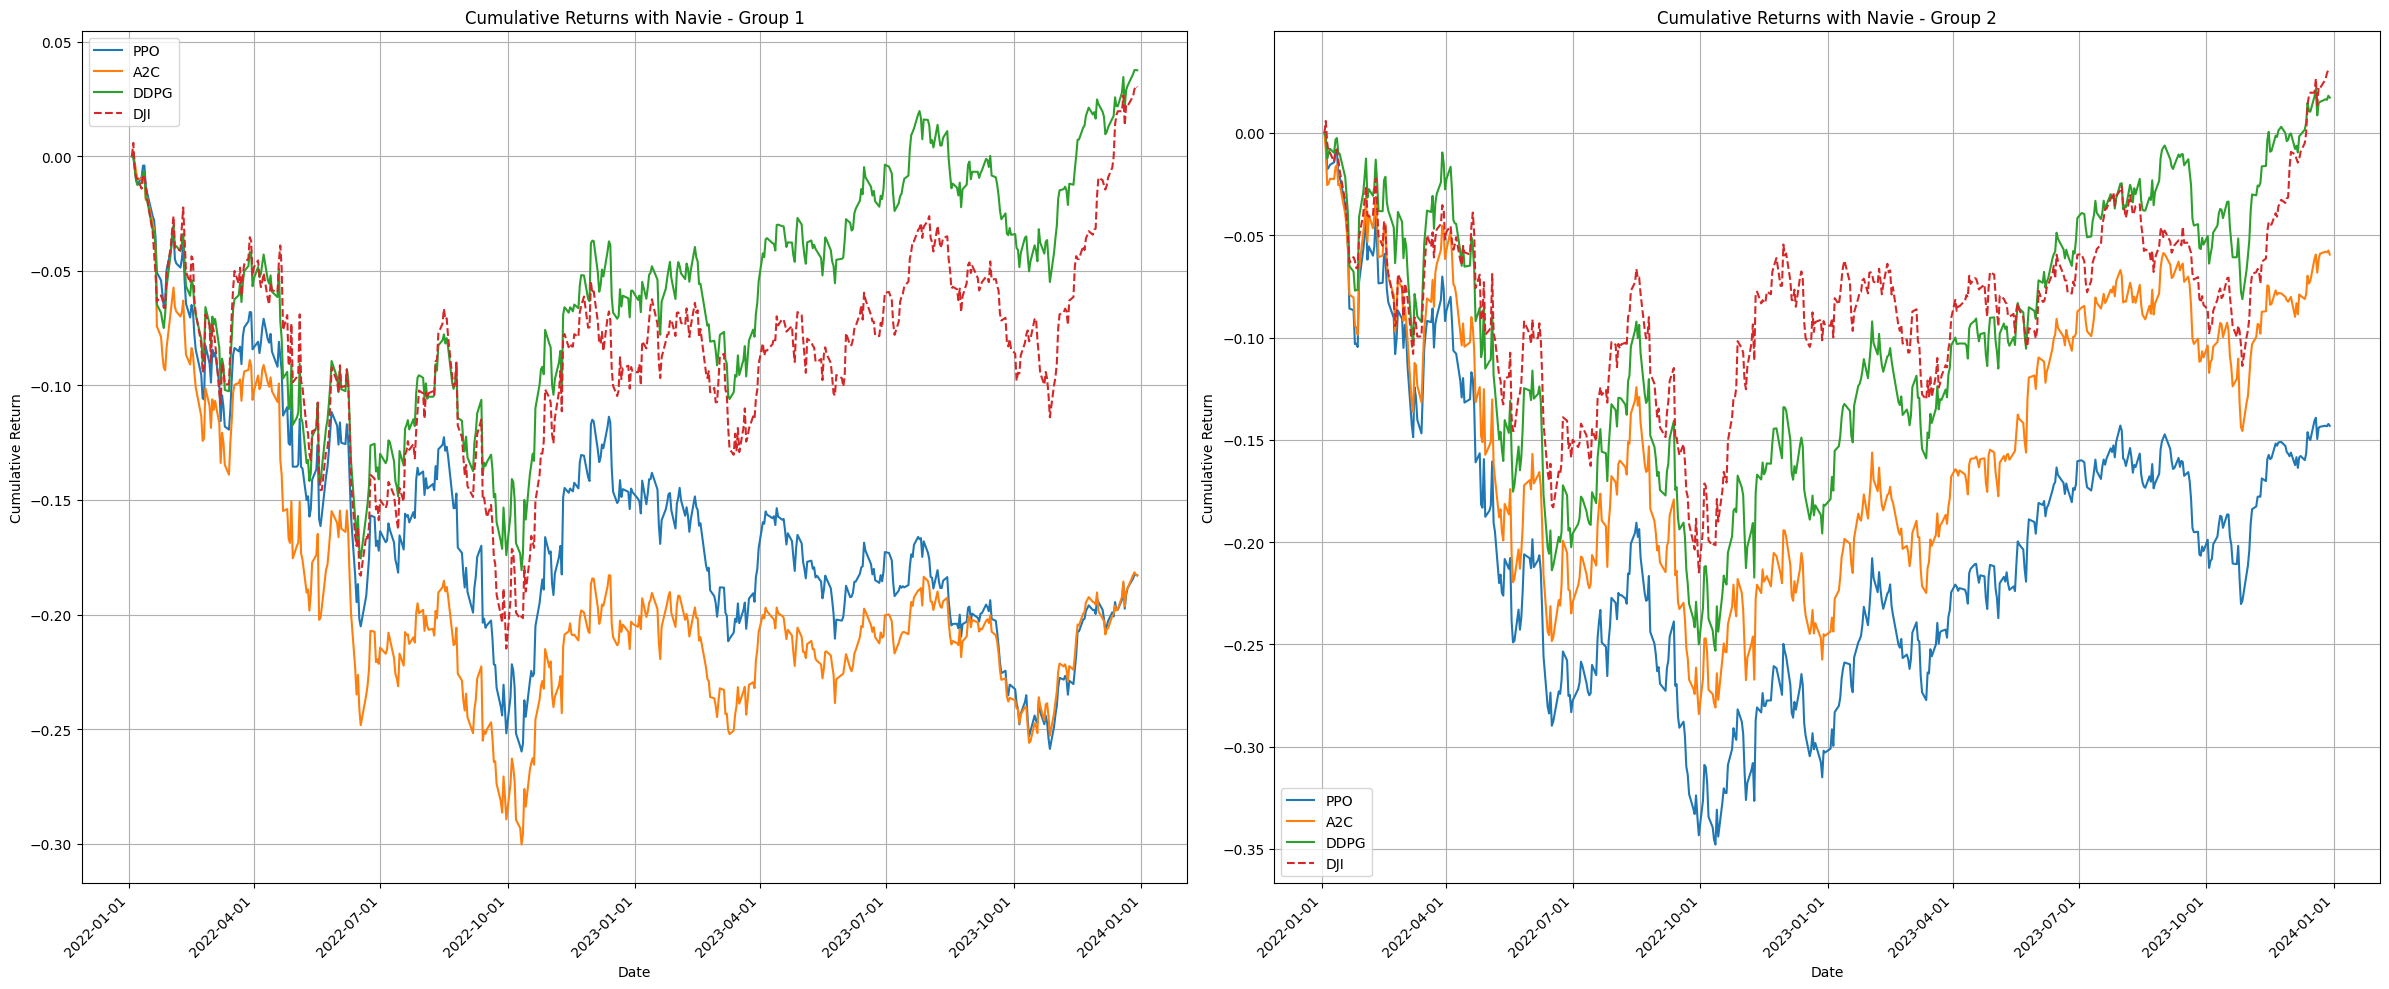

In [32]:
from stable_baselines3 import PPO, A2C, DDPG

# Define the models with their respective classes and filenames
model_files = {
    'PPO': (PPO, os.path.join(model_dir, "ppo_portfolio_model_navie")),
    'A2C': (A2C, os.path.join(model_dir, "a2c_portfolio_model_navie")),
    'DDPG': (DDPG, os.path.join(model_dir, "ddpg_portfolio_model_navie"))
}

# Create the test environment
group1_env = PortfolioAllocationEnv(df=trade_df1, initial_balance=100000, tic_list=group1, transaction_fee_rate=0.001)
group2_env = PortfolioAllocationEnv(df=trade_df2, initial_balance=100000, tic_list=group2, transaction_fee_rate=0.001)
envs = {
    'Group 1': group1_env,
    'Group 2': group2_env
}

# Define the benchmark
benchmarks = {
    'Group 1':('DJI', dji_data['Close']),
    'Group 2':('DJI', dji_data['Close'])
}

# Call the function
plot_agent_performance_multiple_envs(model_files, envs, benchmarks, "Cumulative Returns with Navie")

## Contrinul Learning Strategy: EWC
### Concept
EWC mitigates catastrophic forgetting by adding a regularization term to the loss function, which penalizes changes to important parameters from the previous task.

### Implementation Steps
Implementing EWC requires modifying the training loop to include the EWC regularization term. Since stable_baselines3 does not support EWC out of the box, we'll need to:

Extract the Fisher Information Matrix (FIM) from the pre-trained models.
Modify the loss function to include the EWC term.
Implement a custom policy or algorithm class.

In [33]:
import torch
from torch.utils.data import DataLoader, TensorDataset

def create_dataloader(agent, env, desired_num_observations=10000, batch_size=64, use_agent_policy=True):
    """
    Creates a DataLoader from observations collected using the agent in the given environment.

    Parameters:
    - agent: The pre-trained agent used to collect observations.
    - env: The environment from which to collect observations.
    - desired_num_observations: The number of observations to collect.
    - batch_size: The batch size for the DataLoader.
    - use_agent_policy: If True, use the agent's policy to select actions; if False, use random actions.

    Returns:
    - dataloader: A DataLoader containing the observations.
    """
    # Initialize storage for observations
    observations = []
    
    # Reset the environment to start collecting data
    obs, _ = env.reset()
    done = False
    steps = 0  # Counter for steps in the current episode

    while True:
        observations.append(obs)
        if use_agent_policy:
            # Use the agent's policy to select an action
            action, _ = agent.predict(obs)
        else:
            # Use a random action
            action = env.action_space.sample()
        obs, reward, done, truncated, info = env.step(action)
        steps += 1
        if done or truncated:
            obs, _ = env.reset()
            steps = 0  # Reset step counter for new episode
        if len(observations) >= desired_num_observations:
            break
    
    # Convert observations to a PyTorch tensor
    observations_array = np.array(observations)
    if len(observations_array.shape) == 1:
        observations_array = np.expand_dims(observations_array, axis=-1)
    observations_tensor = torch.tensor(observations_array, dtype=torch.float32)
    
    # Move tensor to the same device as the agent
    observations_tensor = observations_tensor.to(agent.device)
    
    # Create a TensorDataset and DataLoader
    dataset = TensorDataset(observations_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return dataloader



In [34]:
import torch

class EWC:
    def __init__(self, agent, dataloader, lambda_=0.4):
        self.agent = agent
        self.lambda_ = lambda_
        self.params = {n: p.clone().detach() for n, p in agent.policy.named_parameters() if p.requires_grad}
        self.fisher_matrix = self.calculate_fisher_information(dataloader)
    
    def calculate_fisher_information(self, dataloader):
        fisher_matrix = {}
        for n, p in self.params.items():
            fisher_matrix[n] = torch.zeros_like(p)

        for data in dataloader:
            obs = data[0]  # Corrected indexing
            # Ensure observations are on the correct device
            obs = obs.to(self.agent.device)
            
            # Move obs to CPU and convert to NumPy array
            obs_numpy = obs.cpu().numpy()
    
            action, _ = self.agent.policy.predict(obs_numpy, deterministic=True)
            action_tensor = torch.tensor(action).to(self.agent.device)
            
            # Forward pass through the policy network
            log_prob = self.agent.policy.evaluate_actions(obs, action_tensor)[1]
            loss = -log_prob.mean()  # Maximize log probability
            self.agent.policy.optimizer.zero_grad()
            loss.backward()

            # Accumulate Fisher Information
            for n, p in self.agent.policy.named_parameters():
                if p.grad is not None:
                    fisher_matrix[n] += p.grad ** 2

        # Normalize Fisher Information
        for n in fisher_matrix:
            fisher_matrix[n] /= len(dataloader)
        return fisher_matrix

    def penalty(self):
        penalty_loss = 0
        for n, p in self.agent.policy.named_parameters():
            if p.requires_grad:
                penalty_loss += (self.fisher_matrix[n] * (p - self.params[n]) ** 2).sum()
        return (self.lambda_ / 2) * penalty_loss

In [35]:
from stable_baselines3 import PPO
from stable_baselines3.common.policies import ActorCriticPolicy
import torch.nn.functional as F
import torch

class EWC_PPO(PPO):
    def __init__(self, *args, ewc=None, **kwargs):
        super(EWC_PPO, self).__init__(*args, **kwargs)
        self.ewc = ewc

    def train(self):
        # Set the policy to training mode
        self.policy.set_training_mode(True)
        # Update learning rate
        self._update_learning_rate(self.policy.optimizer)

        # Evaluate clip range
        clip_range = self.clip_range
        if callable(clip_range):
            clip_range = clip_range(self._current_progress_remaining)

        # If using clip_range_vf, evaluate it similarly
        clip_range_vf = self.clip_range_vf
        if callable(clip_range_vf):
            clip_range_vf = clip_range_vf(self._current_progress_remaining)

        entropy_losses = []
        pg_losses, value_losses = [], []
        clip_fractions = []
        approx_kl_divs = []

        for epoch in range(self.n_epochs):
            for rollout_data in self.rollout_buffer.get(self.batch_size):
                # Compute values and log probabilities
                values, log_prob, entropy = self.policy.evaluate_actions(
                    rollout_data.observations, rollout_data.actions
                )
                values = values.flatten()
                # Normalize advantages
                advantages = rollout_data.advantages
                if self.normalize_advantage:
                    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
                # Compute ratio
                ratio = torch.exp(log_prob - rollout_data.old_log_prob)
                # Compute policy loss
                surr1 = ratio * advantages
                surr2 = torch.clamp(ratio, 1 - clip_range, 1 + clip_range) * advantages  # Use evaluated clip_range
                policy_loss = -torch.min(surr1, surr2).mean()
                # Compute value loss
                values_pred = values
                if self.clip_range_vf is not None:
                    # Clip the value prediction
                    values_pred_clipped = rollout_data.old_values + torch.clamp(
                        values_pred - rollout_data.old_values, -clip_range_vf, clip_range_vf
                    )
                    value_loss = F.mse_loss(rollout_data.returns, values_pred_clipped)
                else:
                    value_loss = F.mse_loss(rollout_data.returns, values_pred)
                # Compute entropy loss
                entropy_loss = -torch.mean(entropy)
                # Compute total loss
                loss = policy_loss + self.ent_coef * entropy_loss + self.vf_coef * value_loss

                # Add EWC penalty
                if self.ewc is not None:
                    ewc_penalty = self.ewc.penalty()
                    loss += ewc_penalty

                # Optimization step
                self.policy.optimizer.zero_grad()
                loss.backward()
                # Clip gradients if needed
                torch.nn.utils.clip_grad_norm_(self.policy.parameters(), self.max_grad_norm)
                self.policy.optimizer.step()

                # Log losses
                pg_losses.append(policy_loss.item())
                value_losses.append(value_loss.item())
                entropy_losses.append(entropy_loss.item())

                # Compute approximate KL divergence
                approx_kl_div = (rollout_data.old_log_prob - log_prob).mean().item()
                approx_kl_divs.append(approx_kl_div)
                # Compute clip fraction
                clip_fraction = torch.mean((torch.abs(ratio - 1) > clip_range).float()).item()
                clip_fractions.append(clip_fraction)



In [36]:
import os
from stable_baselines3 import PPO

# Create the training environments
group1_env = PortfolioAllocationEnv(df=train_df1, initial_balance=100000, tic_list=group1, transaction_fee_rate=0.001)
group2_env = PortfolioAllocationEnv(df=train_df2, initial_balance=100000, tic_list=group2, transaction_fee_rate=0.001)

# Step 1: Load the pre-trained group1 agent
group1_model_path = os.path.join(model_dir, "ppo_portfolio_model_group1_v1")
ppo_model_group1 = PPO.load(group1_model_path)

# Step 2: Create the DataLoader from group1 data
train_group1_dataloader = create_dataloader(
    agent=ppo_model_group1,
    env=group1_env,
    desired_num_observations=10000,
    batch_size=64,
    use_agent_policy=True
)

# Step 3: Initialize the EWC instance
ewc = EWC(agent=ppo_model_group1, dataloader=train_group1_dataloader, lambda_=0.4)

# Step 4: Create the EWC_PPO agent with the EWC instance
ewc_ppo_agent = EWC_PPO(
    policy=ppo_model_group1.policy.__class__,
    env=group2_env,
    ewc=ewc,
    verbose=1
)

# Load the pre-trained weights
ewc_ppo_agent.policy.load_state_dict(ppo_model_group1.policy.state_dict())

# Step 5: Train the EWC_PPO agent on group2 data
total_timesteps = 50000  # Adjust as needed
ewc_ppo_agent.learn(total_timesteps=total_timesteps)

# Step 6: Save the trained EWC_PPO agent
ewc_ppo_agent.save(os.path.join(model_dir, "ppo_portfolio_model_ewc"))

# Step 7: Evaluate the agent on both group1 and group2 test data
# (As shown in the evaluation section above)


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 304  |
|    iterations      | 1    |
|    time_elapsed    | 6    |
|    total_timesteps | 2048 |
-----------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.52e+03 |
|    ep_rew_mean     | 3.16e+08 |
| time/              |          |
|    fps             | 278      |
|    iterations      | 2        |
|    time_elapsed    | 14       |
|    total_timesteps | 4096     |
| train/             |          |
|    learning_rate   | 0.0003   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.52e+03 |
|    ep_rew_mean     | 3.09e+08 |
| time/              |          |
|    fps             | 270      |
|    iterations      | 3        |
|    time_elapsed    | 22       |
|    total_time

In [37]:
from stable_baselines3 import A2C
import torch
import torch.nn.functional as F

class EWC_A2C(A2C):
    def __init__(self, *args, ewc=None, **kwargs):
        super(EWC_A2C, self).__init__(*args, **kwargs)
        self.ewc = ewc

    def train(self):
        # Switch to train mode
        self.policy.set_training_mode(True)
        # Update optimizer learning rate
        self._update_learning_rate(self.policy.optimizer)

        # Initialize lists to accumulate losses
        policy_losses = []
        value_losses = []
        entropy_losses = []
        ewc_penalties = []

        # Sample minibatches of transitions
        for rollout_data in self.rollout_buffer.get(batch_size=None):
            # Unpack the data
            observations = rollout_data.observations
            actions = rollout_data.actions
            old_values = rollout_data.old_values
            old_log_prob = rollout_data.old_log_prob
            advantages = rollout_data.advantages
            returns = rollout_data.returns

            # Flatten the actions in case of discrete action space
            if isinstance(self.action_space, gym.spaces.Discrete):
                actions = actions.long().flatten()

            # Evaluate the current policy
            values, log_prob, entropy = self.policy.evaluate_actions(observations, actions)
            values = values.flatten()

            # Normalize advantages
            if self.normalize_advantage:
                advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

            # Policy loss
            policy_loss = -(advantages * log_prob).mean()

            # Value loss
            value_loss = F.mse_loss(returns, values)

            # Entropy loss
            entropy_loss = -torch.mean(entropy)

            # Total loss
            loss = policy_loss + self.ent_coef * entropy_loss + self.vf_coef * value_loss

            # Add EWC penalty
            if self.ewc is not None:
                ewc_penalty = self.ewc.penalty()
                loss += ewc_penalty
                ewc_penalties.append(ewc_penalty.item())
            else:
                ewc_penalty = 0.0

            # Perform optimization
            self.policy.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.policy.parameters(), self.max_grad_norm)
            self.policy.optimizer.step()

            # Accumulate losses
            policy_losses.append(policy_loss.item())
            value_losses.append(value_loss.item())
            entropy_losses.append(entropy_loss.item())

        # Log average losses
        self.logger.record("train/policy_loss", np.mean(policy_losses))
        self.logger.record("train/value_loss", np.mean(value_losses))
        self.logger.record("train/entropy_loss", np.mean(entropy_losses))
        if self.ewc is not None:
            self.logger.record("train/ewc_penalty", np.mean(ewc_penalties))



In [38]:
from stable_baselines3 import A2C

# Create the training environments
group1_env = PortfolioAllocationEnv(df=train_df1, initial_balance=100000, tic_list=group1, transaction_fee_rate=0.001)
group2_env = PortfolioAllocationEnv(df=train_df2, initial_balance=100000, tic_list=group2, transaction_fee_rate=0.001)

# Load the pre-trained A2C agent
group1_model_path = os.path.join(model_dir, "a2c_portfolio_model_group1_v1")
a2c_model_group1 = A2C.load(group1_model_path)

# Create the DataLoader from group1 data
train_group1_dataloader = create_dataloader(
    agent=a2c_model_group1,
    env=group1_env,
    desired_num_observations=10000,
    batch_size=64,
    use_agent_policy=True
)

# Initialize the EWC instance
ewc = EWC(agent=a2c_model_group1, dataloader=train_group1_dataloader, lambda_=0.4)

# Create the EWC_A2C agent
ewc_a2c_agent = EWC_A2C(
    policy=a2c_model_group1.policy.__class__,
    env=group2_env,
    ewc=ewc,
    verbose=1
)

# Load the pre-trained policy weights
ewc_a2c_agent.policy.load_state_dict(a2c_model_group1.policy.state_dict())

# Train the agent
total_timesteps = 80000  # Adjust as needed
ewc_a2c_agent.learn(total_timesteps=total_timesteps)

# Step 6: Save the trained EWC_PPO agent
ewc_ppo_agent.save(os.path.join(model_dir, "a2c_portfolio_model_ewc"))


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| time/              |          |
|    fps             | 242      |
|    iterations      | 100      |
|    time_elapsed    | 2        |
|    total_timesteps | 500      |
| train/             |          |
|    entropy_loss    | -20      |
|    ewc_penalty     | 0        |
|    learning_rate   | 0.0007   |
|    policy_loss     | 4.88e+06 |
|    value_loss      | 8.94e+10 |
---------------------------------
---------------------------------
| time/              |          |
|    fps             | 242      |
|    iterations      | 200      |
|    time_elapsed    | 4        |
|    total_timesteps | 1000     |
| train/             |          |
|    entropy_loss    | -19.9    |
|    ewc_penalty     | 0        |
|    learning_rate   | 0.0007   |
|    policy_loss     | 7.17e+06 |
|    value_loss      | 1.77e+11 |
---------------------------------
---------------------

In [39]:
class Deterministic_EWC:
    def __init__(self, agent, dataloader, lambda_=0.4):
        self.agent = agent  # The pre-trained agent
        self.lambda_ = lambda_
        # Store the parameters of the actor network
        self.params = {n: p.clone().detach() for n, p in agent.actor.named_parameters() if p.requires_grad}
        self.fisher_matrix = self.calculate_fisher_information(dataloader)

    def calculate_fisher_information(self, dataloader):
        fisher_matrix = {}
        for n, p in self.params.items():
            fisher_matrix[n] = torch.zeros_like(p)

        for data in dataloader:
            obs = data[0].to(self.agent.device)
            # Get actions from the pre-trained actor
            actions = self.agent.actor(obs)
            # Do not detach actions
            # Optionally add small noise to simulate stochasticity
            noise = torch.normal(0, 1e-6, size=actions.shape).to(actions.device)
            actions_noisy = actions + noise
            # Compute approximate log probabilities
            log_probs = -0.5 * ((actions_noisy) ** 2).sum(dim=1)
            loss = -log_probs.mean()
            self.agent.actor.zero_grad()
            loss.backward()

            # Accumulate Fisher Information
            for n, p in self.agent.actor.named_parameters():
                if p.grad is not None:
                    fisher_matrix[n] += p.grad.data.clone() ** 2

        # Normalize Fisher Information
        for n in fisher_matrix:
            fisher_matrix[n] /= len(dataloader)
        return fisher_matrix

    def penalty(self, network):
        penalty_loss = 0
        for n, p in network.named_parameters():
            if p.requires_grad:
                penalty_loss += (self.fisher_matrix[n] * (p - self.params[n]) ** 2).sum()
        return (self.lambda_ / 2) * penalty_loss


In [40]:
from stable_baselines3 import DDPG
from stable_baselines3.common.utils import polyak_update
import torch as th
import torch.nn.functional as F

class EWC_DDPG(DDPG):
    def __init__(self, *args, ewc=None, **kwargs):
        super(EWC_DDPG, self).__init__(*args, **kwargs)
        self.ewc = ewc

    def train(self, gradient_steps: int, batch_size: int = 100) -> None:
        # Switch to train mode (this affects batch norm / dropout)
        self.policy.set_training_mode(True)

        # Update learning rate according to lr schedule
        self._update_learning_rate([self.actor.optimizer, self.critic.optimizer])

        actor_losses, critic_losses, ewc_penalties = [], [], []
        for _ in range(gradient_steps):
            self._n_updates += 1
            # Sample replay buffer
            replay_data = self.replay_buffer.sample(batch_size, env=self._vec_normalize_env)  # type: ignore[union-attr]

            with th.no_grad():
                # Select action according to policy and add clipped noise
                noise = replay_data.actions.clone().data.normal_(0, self.target_policy_noise)
                noise = noise.clamp(-self.target_noise_clip, self.target_noise_clip)
                next_actions = (self.actor_target(replay_data.next_observations) + noise).clamp(-1, 1)

                # Compute the next Q-values: min over all critics targets
                next_q_values = th.cat(self.critic_target(replay_data.next_observations, next_actions), dim=1)
                next_q_values, _ = th.min(next_q_values, dim=1, keepdim=True)
                target_q_values = replay_data.rewards + (1 - replay_data.dones) * self.gamma * next_q_values

            # Get current Q-values estimates for each critic network
            current_q_values = self.critic(replay_data.observations, replay_data.actions)

            # Compute critic loss
            critic_loss = sum(F.mse_loss(current_q, target_q_values) for current_q in current_q_values)
            assert isinstance(critic_loss, th.Tensor)
            critic_losses.append(critic_loss.item())

            # Optimize the critics
            self.critic.optimizer.zero_grad()
            critic_loss.backward()
            self.critic.optimizer.step()

            # Delayed policy updates
            if self._n_updates % self.policy_delay == 0:
                # Compute actor loss
                actor_loss = -self.critic.q1_forward(replay_data.observations, self.actor(replay_data.observations)).mean()
                
                # Add EWC penalty to actor loss
                if self.ewc is not None:
                    ewc_penalty = self.ewc.penalty(self.actor)
                    actor_loss += ewc_penalty
                    ewc_penalties.append(ewc_penalty.item())

                actor_losses.append(actor_loss.item())

                # Optimize the actor
                self.actor.optimizer.zero_grad()
                actor_loss.backward()
                self.actor.optimizer.step()

                polyak_update(self.critic.parameters(), self.critic_target.parameters(), self.tau)
                polyak_update(self.actor.parameters(), self.actor_target.parameters(), self.tau)
                # Copy running stats, see GH issue #996
                polyak_update(self.critic_batch_norm_stats, self.critic_batch_norm_stats_target, 1.0)
                polyak_update(self.actor_batch_norm_stats, self.actor_batch_norm_stats_target, 1.0)

        self.logger.record("train/n_updates", self._n_updates, exclude="tensorboard")
        if len(actor_losses) > 0:
            self.logger.record("train/actor_loss", np.mean(actor_losses))
        self.logger.record("train/critic_loss", np.mean(critic_losses))





In [41]:
from stable_baselines3 import DDPG

# Create the training environments
group1_env = PortfolioAllocationEnv(df=train_df1, initial_balance=100000, tic_list=group1, transaction_fee_rate=0.001)
group2_env = PortfolioAllocationEnv(df=train_df2, initial_balance=100000, tic_list=group2, transaction_fee_rate=0.001)

# Load the pre-trained DDPG agent
group1_model_path = os.path.join(model_dir, "ddpg_portfolio_model_group1_v1")
ddpg_model_group1 = DDPG.load(group1_model_path)

# Create the DataLoader from group1 data
train_group1_dataloader = create_dataloader(
    agent=ddpg_model_group1,
    env=group1_env,
    desired_num_observations=10000,
    batch_size=64,
    use_agent_policy=True
)

# Initialize the EWC instance
ewc = Deterministic_EWC(agent=ddpg_model_group1, dataloader=train_group1_dataloader, lambda_=0.4)

# Create the EWC_DDPG agent
ewc_ddpg_agent = EWC_DDPG(
    policy=ddpg_model_group1.policy.__class__,
    env=group2_env,
    ewc=ewc,
    verbose=1,
    # Copy hyperparameters from the pre-trained agent
    buffer_size=ddpg_model_group1.buffer_size,
    learning_rate=ddpg_model_group1.learning_rate,
    batch_size=ddpg_model_group1.batch_size,
    tau=ddpg_model_group1.tau,
    gamma=ddpg_model_group1.gamma,
    train_freq=ddpg_model_group1.train_freq,
    gradient_steps=ddpg_model_group1.gradient_steps,
    action_noise=ddpg_model_group1.action_noise,
    replay_buffer_class=ddpg_model_group1.replay_buffer_class,
    replay_buffer_kwargs=ddpg_model_group1.replay_buffer_kwargs,
    policy_kwargs=ddpg_model_group1.policy_kwargs,
    seed=ddpg_model_group1.seed,
    device=ddpg_model_group1.device,
)

# Load the pre-trained actor and critic weights
ewc_ddpg_agent.actor.load_state_dict(ddpg_model_group1.actor.state_dict())
ewc_ddpg_agent.critic.load_state_dict(ddpg_model_group1.critic.state_dict())

# Ensure target networks are updated
ewc_ddpg_agent.actor_target.load_state_dict(ewc_ddpg_agent.actor.state_dict())
ewc_ddpg_agent.critic_target.load_state_dict(ewc_ddpg_agent.critic.state_dict())

# Train the agent
total_timesteps = 50000  # Adjust as needed
ewc_ddpg_agent.learn(total_timesteps=total_timesteps)

# Save the trained EWC_DDPG agent
ewc_ddpg_agent.save(os.path.join(model_dir, "ddpg_portfolio_model_ewc"))




Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 2.52e+03  |
|    ep_rew_mean     | 6.24e+08  |
| time/              |           |
|    episodes        | 4         |
|    fps             | 133       |
|    time_elapsed    | 75        |
|    total_timesteps | 10060     |
| train/             |           |
|    actor_loss      | -4.48e+07 |
|    critic_loss     | 3.88e+11  |
|    learning_rate   | 0.001     |
|    n_updates       | 9959      |
----------------------------------
{'Cumulative Return': 4.500987220418073, 'Sharpe Ratio': 0.07341678626094265, 'Max Drawdown': 0.18751306253399402, 'Volatility': 0.00990466729879152}
            Episode                                            Actions  \
Dates                                                                    
2010-01-04        5  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...   
2010-01-

/usr/local/lib/python3.11/dist-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


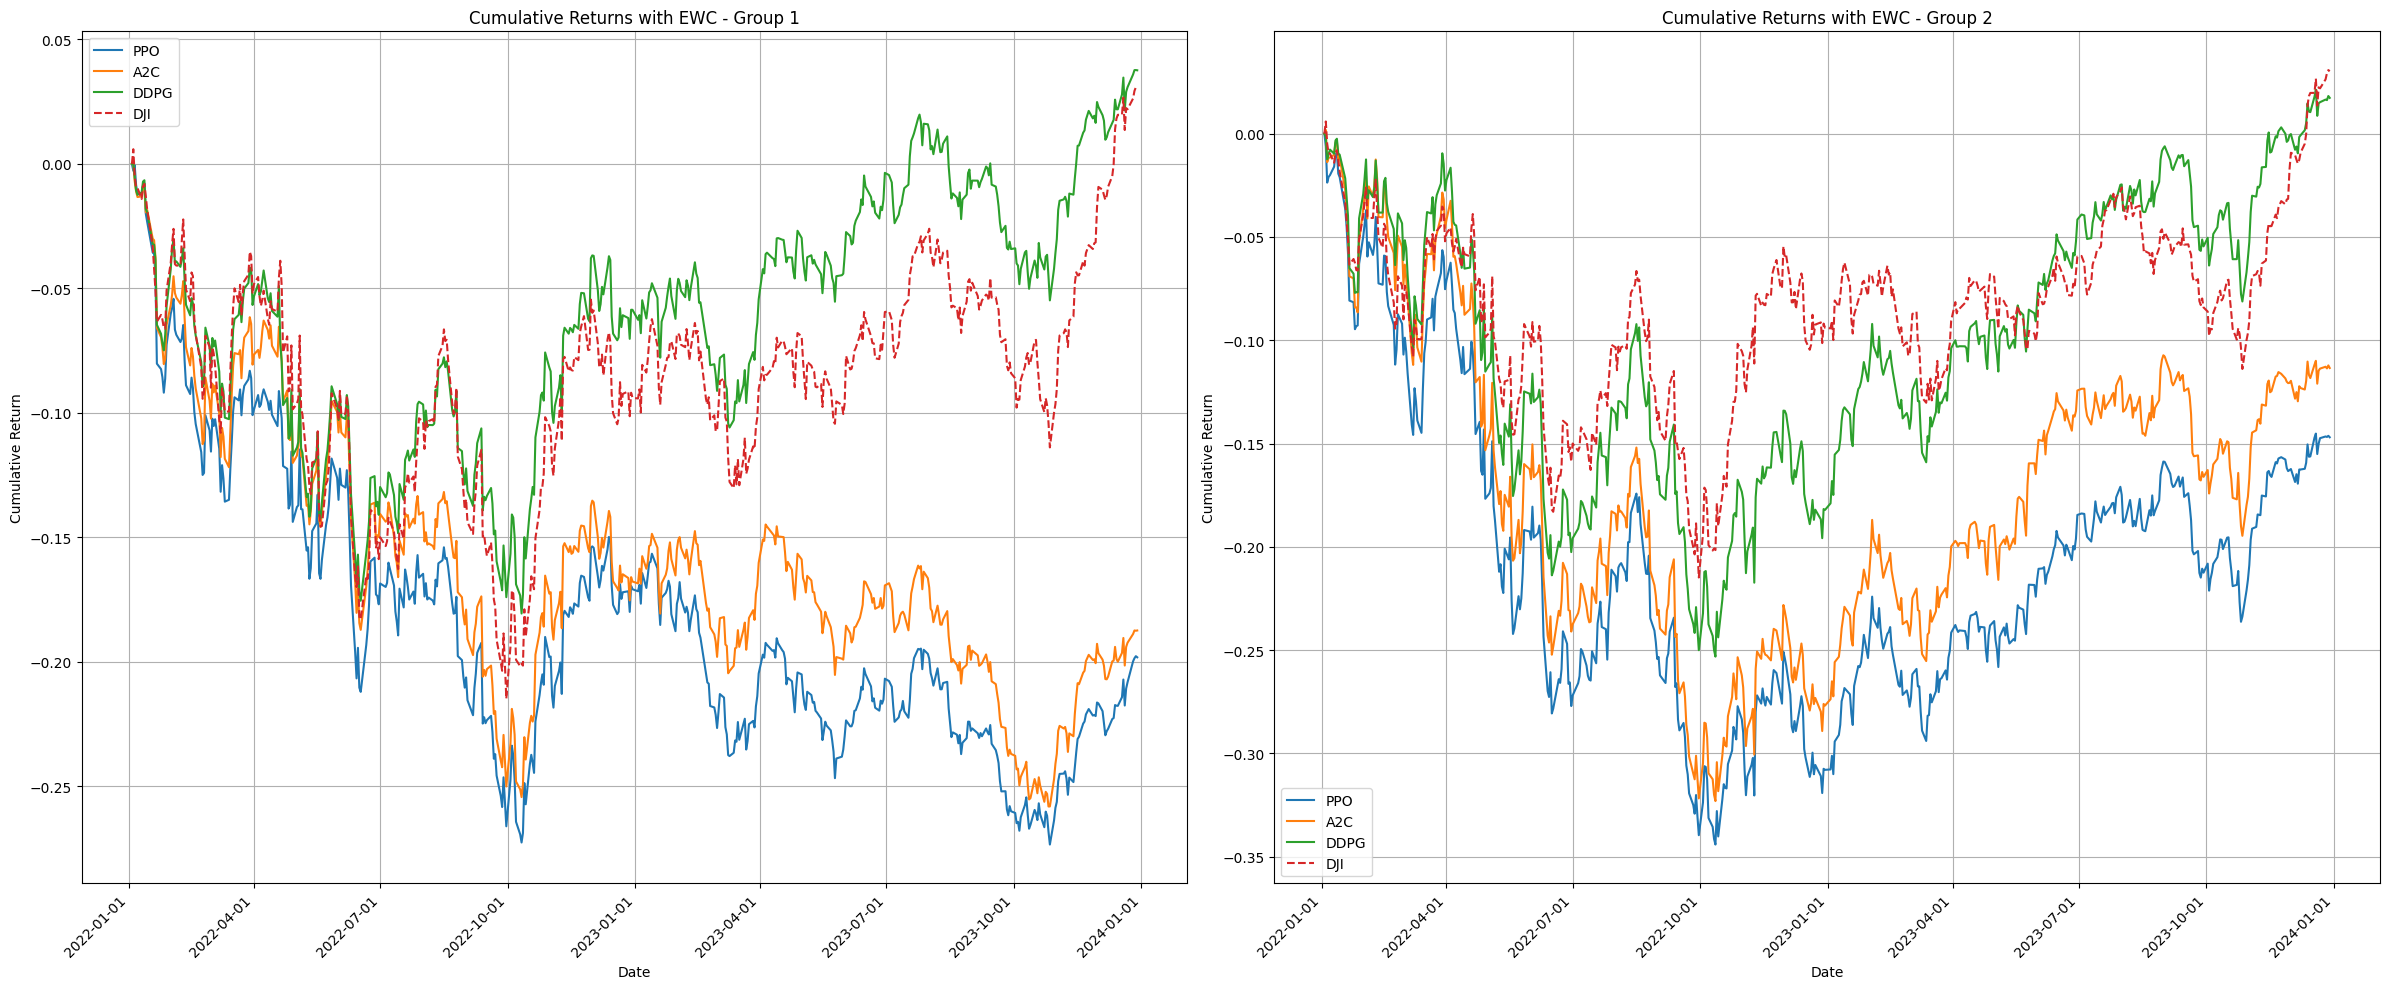

In [42]:
from stable_baselines3 import PPO, A2C, DDPG

# Define the models with their respective classes and filenames
model_files = {
    'PPO': (PPO, os.path.join(model_dir, "ppo_portfolio_model_ewc")),
    'A2C': (A2C, os.path.join(model_dir, "a2c_portfolio_model_ewc")),
    'DDPG': (DDPG, os.path.join(model_dir, "ddpg_portfolio_model_ewc"))
}

# Create the test environment
group1_env = PortfolioAllocationEnv(df=trade_df1, initial_balance=100000, tic_list=group1, transaction_fee_rate=0.001)
group2_env = PortfolioAllocationEnv(df=trade_df2, initial_balance=100000, tic_list=group2, transaction_fee_rate=0.001)
envs = {
    'Group 1': group1_env,
    'Group 2': group2_env
}

# Define the benchmark
benchmarks = {
    'Group 1':('DJI', dji_data['Close']),
    'Group 2':('DJI', dji_data['Close'])
}

# Call the function
plot_agent_performance_multiple_envs(model_files, envs, benchmarks, "Cumulative Returns with EWC")

In [43]:
from stable_baselines3.common.vec_env import DummyVecEnv

# Function to create a new environment with randomly selected 1-year data from group1
def create_group1_env_random(group1_df, tic_list, num_days=252, transaction_fee_rate=0.001, initial_balance=100000):
    group1_df = group1_df.sort_index()
    unique_date = group1_df.index.get_level_values('Date').unique()
    # Ensure there are at least 252 days available
    if len(unique_date) < num_days:
        raise ValueError("Insufficient data for group1.")

    # Randomly select a start date such that 252 days of data are available
    start_idx = random.randint(0, len(unique_date) - num_days)
    end_idx = start_idx + num_days
    selected_dates = unique_date[start_idx:end_idx]

    # Extract the 1-year subset of group1 data
    group1_subset = group1_df.loc[(slice(selected_dates[0], selected_dates[-1]), slice(None))]

    # Create a new environment with the selected data subset
    group1_env = PortfolioAllocationEnv(
        df=group1_subset, 
        initial_balance=initial_balance, 
        tic_list=tic_list, 
        transaction_fee_rate=transaction_fee_rate
    )
    
    # Wrap the environment if necessary (e.g., with DummyVecEnv for compatibility)
    # group1_env = DummyVecEnv([lambda: group1_env])
    
    return group1_env

# Function to create the group2 environment
def create_group2_env(train_df2, tic_list, transaction_fee_rate=0.001, initial_balance=100000):
    group2_env = PortfolioAllocationEnv(
        df=train_df2, 
        initial_balance=initial_balance, 
        tic_list=tic_list, 
        transaction_fee_rate=transaction_fee_rate
    )
    
    # Wrap the environment if necessary
    # group2_env = DummyVecEnv([lambda: group2_env])
    
    return group2_env

In [44]:
import os
import random
import pandas as pd
from stable_baselines3 import DDPG, A2C, PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from datetime import datetime

# Main function to perform training and save the model
def perform_training(train_df1, train_df2, tic_list_group1, tic_list_group2, total_timesteps, 
                     agent_class, agent_filename, model_dir, model_filename,
                    reinforcement_interval=15000, reinforcement_steps=3000, transaction_fee_rate=0.001, initial_balance=100000):
    """
    Trains an RL agent on group2 data with periodic reinforcement on group1 data.

    Parameters:
    - train_df1 (pd.DataFrame): Training data for group1.
    - train_df2 (pd.DataFrame): Training data for group2.
    - tic_list_group1 (list): List of tickers/assets for group1.
    - tic_list_group2 (list): List of tickers/assets for group2.
    - total_timesteps (int): Total number of timesteps for training.
    - agent_class (class): RL agent class from Stable Baselines3 (e.g., DDPG, A2C, PPO).
    - model_dir (str): Directory to save the trained models.
    - reinforcement_interval (int): Timesteps to train on group2 before reinforcement.
    - reinforcement_steps (int): Timesteps to train on group1 during reinforcement.
    - transaction_fee_rate (float): Transaction fee rate for the environment.
    - initial_balance (int): Initial balance for the portfolio.

    Returns:
    - None
    """
    # Ensure the model directory exists
    os.makedirs(model_dir, exist_ok=True)

    # Create the group2 environment
    group2_env = create_group2_env(train_df2, tic_list_group2, transaction_fee_rate, initial_balance)

    # Initialize the agent with group2 environment
    group1_model_path = os.path.join(model_dir, agent_filename)
    agent = agent_class.load(group1_model_path, env=group2_env)

    timesteps_done = 0
    reinforcement_count = 0

    # Loop until the total timesteps are reached
    while timesteps_done < total_timesteps:
        # Determine the remaining timesteps to avoid overshooting
        remaining_timesteps = total_timesteps - timesteps_done
        current_interval = min(reinforcement_interval, remaining_timesteps)

        # Train on group2
        print(f"Training on group2 for {current_interval} timesteps.")
        if (timesteps_done == 0): #Reset the Number of Timesteps at begining of training
            agent.learn(total_timesteps=current_interval, reset_num_timesteps=True)
        else:
            agent.learn(total_timesteps=current_interval, reset_num_timesteps=False)
        timesteps_done += current_interval

        # Check if total_timesteps are reached
        if timesteps_done >= total_timesteps:
            break

        # Create a random group1 environment for reinforcement
        try:
            random_group1_env = create_group1_env_random(
                train_df1, 
                tic_list_group1,
                num_days=int(reinforcement_steps/10), 
                transaction_fee_rate=transaction_fee_rate, 
                initial_balance=initial_balance
            )
        except ValueError as e:
            print(f"Error creating group1 environment: {e}")
            break

        # Set the new environment for the agent
        agent.set_env(random_group1_env)

        # Reinforce group1 knowledge
        reinforcement_steps_current = min(reinforcement_steps, total_timesteps - timesteps_done)
        print(f"Reinforcing group1 memory for {reinforcement_steps_current} timesteps at timestep {timesteps_done}")
        agent.learn(total_timesteps=reinforcement_steps_current, reset_num_timesteps=False)
        timesteps_done += reinforcement_steps_current

        # Switch back to group2 environment
        agent.set_env(group2_env)
        reinforcement_count += 1

    # Final model saving
    final_model_path = os.path.join(model_dir, model_filename)
    agent.save(final_model_path)
    print(f"Final model saved to {final_model_path}")

In [45]:
from stable_baselines3 import DDPG, A2C, PPO

# Choose the agent class (DDPG, A2C, PPO)
agent_class = DDPG  # For example, using PPO

# Perform training
perform_training(
    train_df1=train_df1,
    train_df2=train_df2,
    tic_list_group1=group1,
    tic_list_group2=group2,
    total_timesteps=total_timesteps,
    agent_class=agent_class,
    agent_filename="ddpg_portfolio_model_group1_v1",
    model_dir=model_dir,
    model_filename="ddpg_portfolio_model_replay",
    reinforcement_interval=15000,
    reinforcement_steps=3000,
    transaction_fee_rate=0.001,
    initial_balance=100000
)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Training on group2 for 15000 timesteps.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 2.52e+03  |
|    ep_rew_mean     | 6.28e+08  |
| time/              |           |
|    episodes        | 4         |
|    fps             | 147       |
|    time_elapsed    | 68        |
|    total_timesteps | 10060     |
| train/             |           |
|    actor_loss      | -6.98e+07 |
|    critic_loss     | 1.08e+12  |
|    learning_rate   | 0.001     |
|    n_updates       | 59859     |
----------------------------------
{'Cumulative Return': 4.500987220418073, 'Sharpe Ratio': 0.07341678626094265, 'Max Drawdown': 0.18751306253399402, 'Volatility': 0.00990466729879152}
            Episode                                            Actions  \
Dates                                                                    
2010-01-04        5  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0

In [46]:
from stable_baselines3 import DDPG, A2C, PPO

perform_training(
    train_df1=train_df1,
    train_df2=train_df2,
    tic_list_group1=group1,
    tic_list_group2=group2,
    total_timesteps=50000,
    agent_class=PPO,
    agent_filename="ppo_portfolio_model_group1_v1",
    model_dir=model_dir,
    model_filename="ppo_portfolio_model_replay",
    reinforcement_interval=15000,
    reinforcement_steps=3000,
    transaction_fee_rate=0.001,
    initial_balance=100000
)

perform_training(
    train_df1=train_df1,
    train_df2=train_df2,
    tic_list_group1=group1,
    tic_list_group2=group2,
    total_timesteps=80000,
    agent_class=A2C,
    agent_filename="a2c_portfolio_model_group1_v1",
    model_dir=model_dir,
    model_filename="a2c_portfolio_model_replay",
    reinforcement_interval=15000,
    reinforcement_steps=3000,
    transaction_fee_rate=0.001,
    initial_balance=100000
)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Training on group2 for 15000 timesteps.
-----------------------------
| time/              |      |
|    fps             | 305  |
|    iterations      | 1    |
|    time_elapsed    | 6    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 2.52e+03     |
|    ep_rew_mean          | 2.92e+08     |
| time/                   |              |
|    fps                  | 295          |
|    iterations           | 2            |
|    time_elapsed         | 13           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 1.306762e-08 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -21.3        |
|    explained_variance   | 7.45e-06     |
|    learning_rate        | 

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


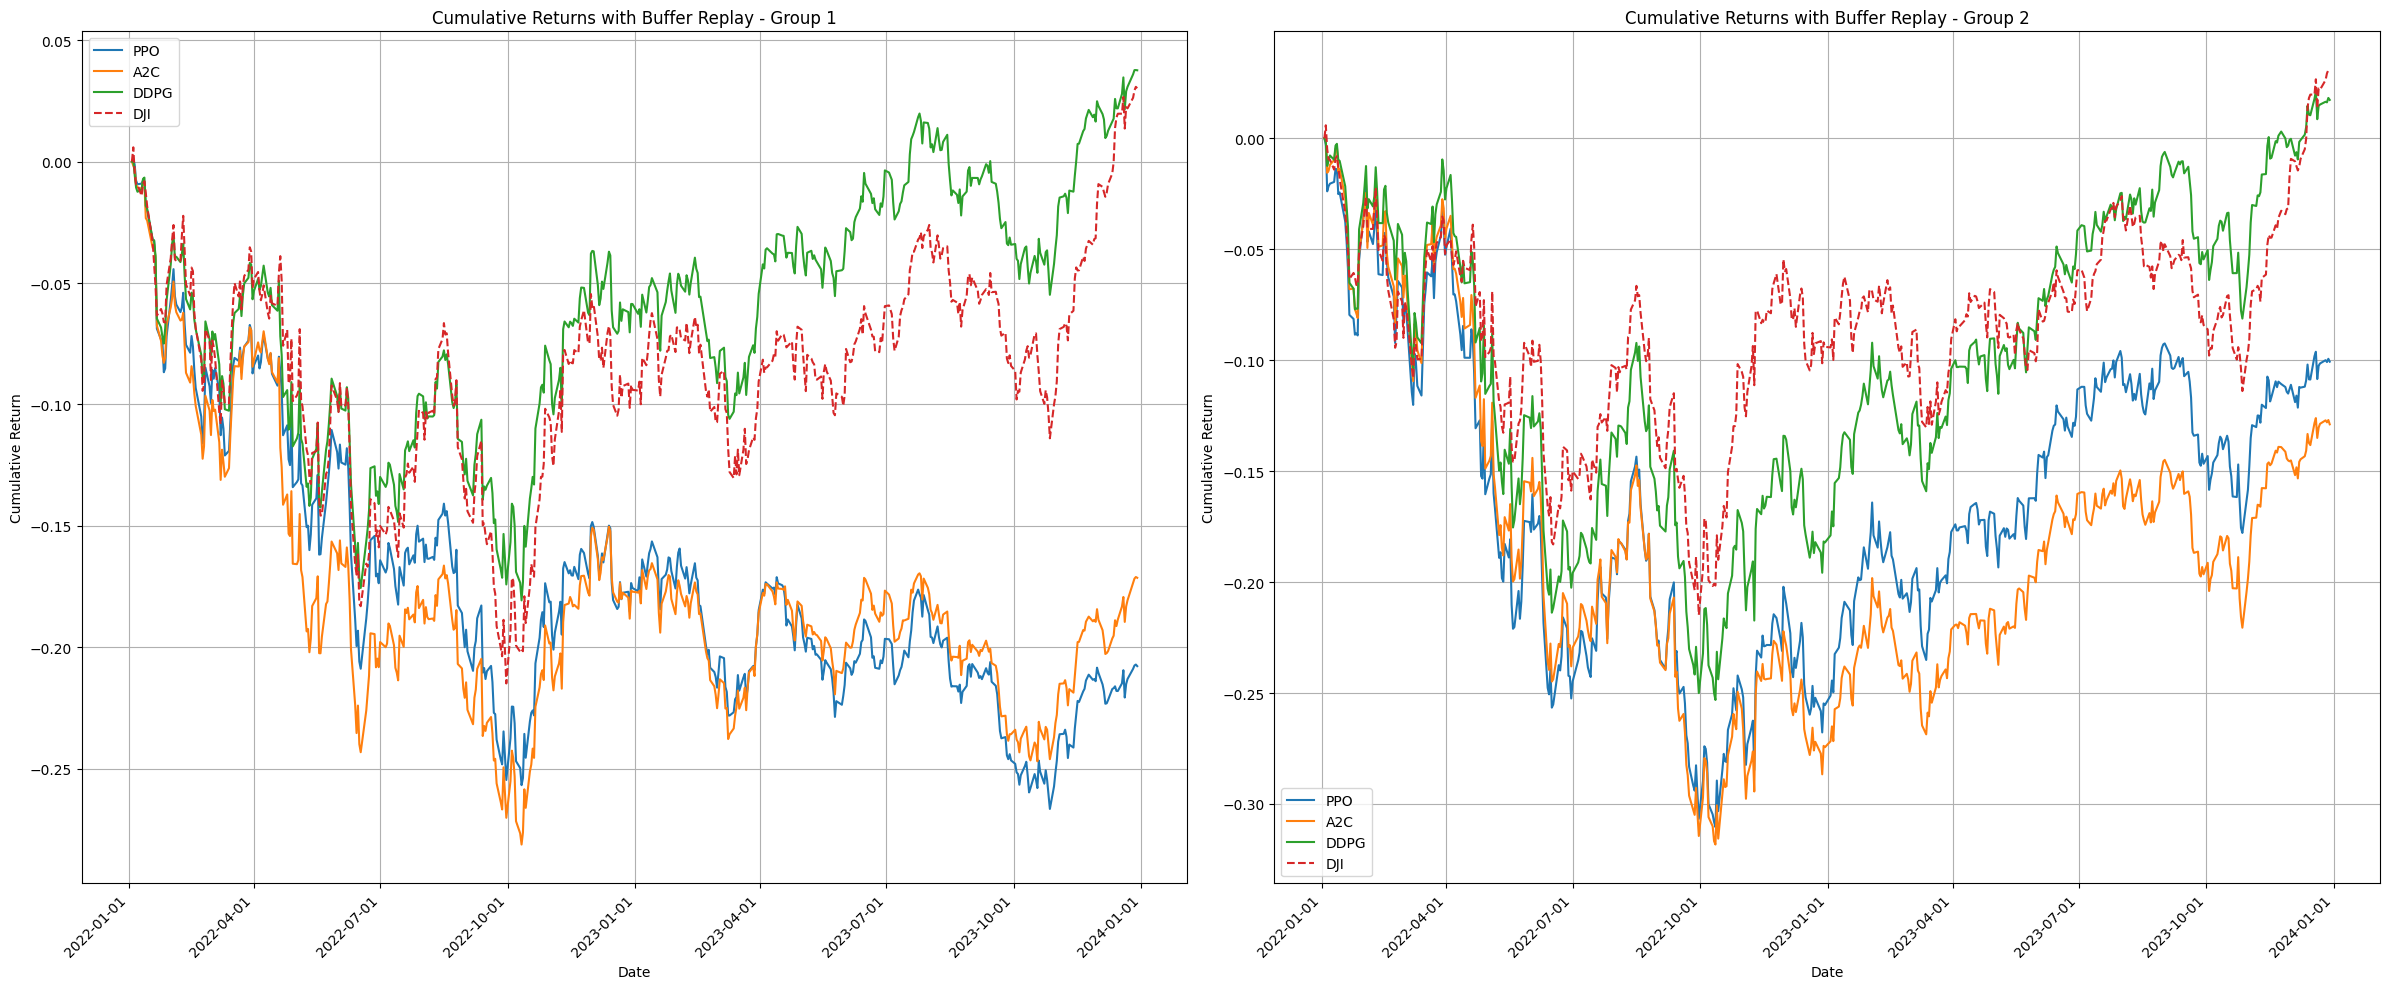

In [47]:
from stable_baselines3 import PPO, A2C, DDPG

# Define the models with their respective classes and filenames
model_files = {
    'PPO': (PPO, os.path.join(model_dir, "ppo_portfolio_model_replay")),
    'A2C': (A2C, os.path.join(model_dir, "a2c_portfolio_model_replay")),
    'DDPG': (DDPG, os.path.join(model_dir, "ddpg_portfolio_model_replay"))
}

# Create the test environment
group1_env = PortfolioAllocationEnv(df=trade_df1, initial_balance=100000, tic_list=group1, transaction_fee_rate=0.001)
group2_env = PortfolioAllocationEnv(df=trade_df2, initial_balance=100000, tic_list=group2, transaction_fee_rate=0.001)
envs = {
    'Group 1': group1_env,
    'Group 2': group2_env
}

# Define the benchmark
benchmarks = {
    'Group 1':('DJI', dji_data['Close']),
    'Group 2':('DJI', dji_data['Close'])
}

# Call the function
plot_agent_performance_multiple_envs(model_files, envs, benchmarks, "Cumulative Returns with Buffer Replay")